In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime, timedelta
from pandas.core.indexes.datetimes import date_range
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Input, LSTM, Concatenate
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from math import sqrt
from matplotlib import pyplot
from numpy import array, concatenate
import numpy as np

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, n_features = 1,
                         pred_id = 0, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    # Drop non-predicting variables
    drop_cols = list(set(range(-n_features*n_out,0)) - \
                set([(-(i+1)*n_features) for i in range(n_out)]))
    
    agg = agg.drop(agg.columns[drop_cols], axis=1)
    return agg

In [ ]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq, n_features, pred_id=0):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), -1)
    print(raw_values.shape)
    
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(raw_values)
    scaled_values = scaled_values.reshape(len(scaled_values), -1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq,
                                      n_features=n_features, 
                                      pred_id=pred_id)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [ ]:
# transform series into train and test sets for supervised learning
def prepare_all_state_data(states, series, n_test, n_lag, n_seq, 
                           nth_week, n_features, n_out=7, pred_id=0):
    train = np.empty((0, n_lag*n_features+n_seq))
    test = np.empty((0, n_lag*n_features+n_seq))
    
    for state in states:
        state_df = series[series['location_name']==state]
        state_df = state_df.drop(['location','location_name', 
                              'hospitalizations', 'cases', 'spc'], axis=1)

        print(f'state_df.shape: {state_df.shape}')

        state_supervised = series_to_supervised(state_df, n_in=n_lag, n_out=n_seq,
                                            n_features=n_features, pred_id=0)
        print(f'state_supervised.shape: {state_supervised.shape}')

        state_supervised_values = state_supervised.values
        state_train, state_test = state_supervised_values[0:-n_test], state_supervised_values[-n_test:]
        
        train_unclean = np.append(train, state_train, axis=0)
        test = np.append(test, state_test, axis=0)
        # all_state_supervised = all_state_supervised.append(state_supervised)
        # print(f'{state} is statcked in DataFrame.')
    
        # print(train.shape, test.shape)
        # # Clean up all data for validation
        train = train_unclean[:-(n_out*nth_week) + 1, :] # if -(n_out*nth_week)+2, leaking first day
    print('Deleted rows: ', n_out*nth_week)
    print('Uncleaned Train shape: ', (len(states)*(state_supervised.shape[0]-1),
                                      state_supervised.shape[1]))
    print('Cleaned Train shape: ', train.shape)
        
    raw_values = np.concatenate((train, test), axis=0)
    print(f'Concatenated Dataframe shape: {raw_values.shape}')
    print(raw_values[1,-(nth_week+1)*n_out:])
    if nth_week >= 2:
        raw_values = np.delete(raw_values, np.s_[n_features*n_lag: n_features*n_lag+n_out*(nth_week-1)], axis=1)
    print(f'Concatenated Dataframe shape of {nth_week}th week: {raw_values.shape}')
    print(raw_values[1,-2*n_out:])
    # # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(raw_values)
    scaled_values = scaled_values.reshape(len(scaled_values), -1)
    
    # split into train and test sets
    train, test = scaled_values[0:-len(test)], scaled_values[-len(test):]
    return scaler, train, test

In [ ]:
def prepare_all_state_data_forecast(states, series, n_test, n_lag, n_seq, 
                           nth_week, n_features, saved_scaler, n_out, pred_id=0):
    train = np.empty((0, n_lag*n_features+n_seq))
    test = np.empty((0, n_lag*n_features+n_seq))
    
    for state in states:
        state_df = series[series['location_name']==state]
        
        # state_df.to_csv(f'/content/gdrive/MyDrive/RS-LSTM_images/state_df/{state}.csv')
        #print(state_df.tail(30))

        state_df = state_df.drop(['location','location_name', 
                              'hospitalizations', 'cases', 'spc'], axis=1)
        
        print(f'state_df.shape: {state_df.shape}')

        state_supervised = series_to_supervised(state_df, n_in=n_lag, n_out=n_seq,
                                            n_features=n_features, pred_id=0)
        
        print(f'state_supervised.shape: {state_supervised.shape}')

        state_supervised_values = state_supervised.values
        state_train, state_test = state_supervised_values[0:-n_test], state_supervised_values[-n_test:]
        
        train_unclean = np.append(train, state_train, axis=0)
        test = np.append(test, state_test, axis=0)
        # all_state_supervised = all_state_supervised.append(state_supervised)
        # print(f'{state} is statcked in DataFrame.')
    
        # print(train.shape, test.shape)
        train = train_unclean[:-(n_out*nth_week) + 1, :] # if -(n_out*nth_week)+2, leaking first day
    raw_values = np.concatenate((train, test), axis=0)
    print(f'Concatenated Dataframe shape: {raw_values.shape}')
    print(raw_values[1,-35:])
    if nth_week >= 2:
        raw_values = np.delete(raw_values, np.s_[n_features*n_lag: n_features*n_lag+n_out*(nth_week-1)], axis=1)
    print(f'Concatenated Dataframe shape of {nth_week}th week: {raw_values.shape}')
    print(raw_values[1,-14:])
    # rescale values to -1, 1
    # scaler = saved_scaler
    scaled_values = scaler.fit_transform(raw_values)
    scaled_values = scaled_values.reshape(len(scaled_values), -1)
    
    # split into train and test sets
    train, test = scaled_values[0:-len(test)], scaled_values[-len(test):]
    return scaler, train, test

In [ ]:
class MultiQuantileLoss(tf.keras.losses.Loss):
    
    def __init__(self, quantiles:list, **kwargs):
        super(MultiQuantileLoss, self).__init__(**kwargs)
        
        self.quantiles = quantiles

    def call(self, y_true, y_pred):
        
        # get quantile value
        q_id = int(y_pred.name.split("/")[1][1:])
        q = self.quantiles[q_id]
        
        # minimize quantile error
        q_error = tf.subtract(y_true, y_pred)
        q_loss = tf.reduce_mean(tf.maximum(q*q_error, (q-1)*q_error), axis=-1)
        return q_loss

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_features, 
             n_seq, n_batch, nb_epoch, 
             n_neurons):
    
    # quantiles = [.1, .5, .9]
    quantiles = [.025, .100, .250, .500, .750, .900, .975]
    # quantiles = [.010, .025, .050, .100, .150, .200, .250, .300, .350, .400, .450, .500,
    #              .550, .600, .650, .700, .750, .800, .850, .900, .950, .975, .990]

    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag*n_features], train[:, n_lag*n_features:]
    X = X.reshape(X.shape[0], n_lag, n_features)
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, activation='tanh',
                   return_sequences=True,
                   input_shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(n_neurons, activation='tanh'))
    model.add(Dense(y.shape[1]))
    # loss=tf.keras.losses.Huber(),mae, mse
    model.compile(loss=tf.keras.losses.Huber(), optimizer='adam') 
    # fit network
    history = model.fit(X, y, epochs=nb_epoch, 
                        batch_size=n_batch,  
                        verbose=2, shuffle=False)
    
    return model

In [ ]:
# fit an LSTM network to training data
def fit_lstm_quantile(train1, train2, n_lag1, n_lag2, 
                      n_features, n_out, n_batch, nb_epoch, 
                      n_neurons, val=False, val_1=None, val_2=None):
    # quantiles = [.025, .100, .250, .500, .750, .900, .975]
    # quantiles = [.050, .500, .950]
    quantiles = [.010, .025, .050, .100, .150, .200, .250, .300, .350, .400, .450, .500,
                 .550, .600, .650, .700, .750, .800, .850, .900, .950, .975, .990]
    output_dim = len(quantiles)
    print(output_dim)
    outputs = []

    # Define a learnable weights
    W = tf.Variable(1.0, trainable=True)

    # reshape training into [samples, timesteps, features]
    X1, y1 = train1[:, 0:n_lag1*n_features], train1[:, n_lag1*n_features:]
    X1 = X1.reshape(X1.shape[0], n_lag1, n_features)
    # reshape training into [samples, timesteps, features]
    X2, y2 = train2[:, 0:n_lag2*n_features], train2[:, n_lag2*n_features:]
    X2 = X2.reshape(X2.shape[0], n_lag2, n_features)

    # design network
    ts_input1 = Input((X1.shape[1], X1.shape[2]))
    lstm1_1_out = LSTM(int(n_neurons), activation="tanh", return_sequences=True)(ts_input1)
    lstm1_2_out = LSTM(int(n_neurons/2), activation="tanh", return_sequences=True)(lstm1_1_out)
    lstm1_3_out = LSTM(int(n_neurons/2), activation='tanh', return_sequences=True)(lstm1_2_out)
    lstm1_4_out = LSTM(int(n_neurons/2), activation='tanh')(lstm1_3_out)
    # lstm1_4_out = LSTM(int(n_neurons/2), activation='tanh')(lstm1_3_out)
    map_lstm1 = Dense(64)(lstm1_4_out)

    # design network
    ts_input2 = Input((X2.shape[1], X2.shape[2]))
    lstm2_1_out = LSTM(int(n_neurons), activation="tanh", return_sequences=True)(ts_input2)
    lstm2_2_out = LSTM(int(n_neurons/2), activation="tanh", return_sequences=True)(lstm2_1_out)
    lstm2_3_out = LSTM(int(n_neurons/2), activation='tanh', return_sequences=True)(lstm2_2_out)
    lstm2_4_out = LSTM(int(n_neurons/2), activation='tanh')(lstm2_3_out)
    # lstm2_4_out = LSTM(int(n_neurons/2), activation='tanh')(lstm2_3_out)
    map_lstm2 = Dense(64)(lstm2_4_out)

    # Concatenate LSTMs
    #lstm_2_out = keras.layers.concatenate([w * map_lstm1, map_lstm2])
    lstm_2_out = keras.layers.Concatenate()([W*map_lstm1, map_lstm2])
    print(f'W: {W}')
    #dense_1_out = Dense(96)(lstm_2_out)
    
#     # create an output for each quantile
#     for i,quantile in enumerate(quantiles):
#         output = Dense(y.shape[1], name="q_"+str(i))(dense_1_out)
#         outputs.append(output)
    outputs = [Dense(n_out, activation='linear', name="q%d" % q_i)(lstm_2_out) for q_i in range(output_dim)]


    # loss
    q_loss = MultiQuantileLoss(quantiles)

    # intialize & compile
    model = Model(inputs=[ts_input1, ts_input2], outputs=outputs)

    # Set Learning rate decay for AdamOpt
    initial_lr = 0.0008 # Default for adam is 0.001
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_lr,
    #     decay_steps=3000,
    #     decay_rate=0.96,
    #     staircase=True
    #     )
    Adam_Opt = tf.keras.optimizers.Adam(initial_lr)

    # Compile the model
    model.compile(optimizer=Adam_Opt, loss=q_loss.call)
    # Huber Loss
    # model.compile(optimizer=Adam_Opt, loss=tf.keras.losses.Huber())
    
    print(y1.shape)
    logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, 
                       restore_best_weights=False) 


    if val != False:
      print('Has Validation!')
      # Random Validation
      if val == 'Random':
        print('Random Validation Split!')
        val_pct = 0.05
        # Validation Preparation
        ## Preparing for validation set
        val_idx = np.random.randint(0, len(train1), int(val_pct*len(train1)))
        
        # val_1 = train1[val_idx]
        # val_2 = train2[val_idx]

        # train1 = np.delete(train1, val_idx, axis=0)
        # train2 = np.delete(train2, val_idx, axis=0)

        # val_1, val_2 = train1[-1,], train2[-1,]
        val_X1, val_y = val_1[:, 0:n_lag1*n_features], val_1[:, n_lag1*n_features:]
        val_X1 = val_X1.reshape((val_X1.shape[0], n_lag1, n_features))

        val_X2, val_y = val_2[:, 0:n_lag2*n_features], val_2[:, n_lag2*n_features:]
        val_X2 = val_X2.reshape((val_X2.shape[0], n_lag2, n_features))

        # fit network
        history = model.fit([X1, X2], y1, epochs=nb_epoch, 
                            batch_size=n_batch,  
                            verbose=2, shuffle=False, 
                            # validation_split=0.01,
                            validation_data=([val_X1, val_X2], val_y), 
                            callbacks=[tensorboard_callback, es])
      elif val == 'Recent':
        print('Recent Validation Split!')
        train_idx = []
        for i in range(51):
          for j in range(51):
            train_idx = train_idx + [int(i + (j * train1.shape[0] / 51))]
        
        train1 = train1[train_idx]
        train2 = train2[train_idx]

        # fit network
        history = model.fit([X1, X2], y1, epochs=nb_epoch, 
                            batch_size=n_batch,  
                            verbose=2, shuffle=False, 
                            validation_split=0.05,
                            # validation_data=([val_X1, val_X2], val_y), 
                            callbacks=[tensorboard_callback, es])
      else:
        print('Default (State) Validation Split!')
        print(f'Validation Pct. : {val}')
        # Default Validation Split 
        # Last state's data as validation
        # Validation Preparation
        ## Preparing for validation set
        # val_idx = [int((-1) - n * (train1.shape[0] / 51 )) for n in range(51)]

        # train1 = np.delete(train1, val_idx, axis=0)
        # train2 = np.delete(train2, val_idx, axis=0)

        # val_1 = train1[val_idx]
        # val_2 = train2[val_idx]
        # # val_1, val_2 = train1[-1,], train2[-1,]
        # val_X1, val_y = val_1[:, 0:n_lag1*n_features], val_1[:, n_lag1*n_features:]
        # val_X1 = val_X1.reshape((val_X1.shape[0], n_lag1, n_features))

        # val_X2, val_y = val_2[:, 0:n_lag2*n_features], val_2[:, n_lag2*n_features:]
        # val_X2 = val_X2.reshape((val_X2.shape[0], n_lag2, n_features))
        
        # fit network
        history = model.fit([X1, X2], y1, epochs=nb_epoch, 
                            batch_size=n_batch,  
                            verbose=2, shuffle=False, 
                            validation_split=val,
                            #validation_data=([val_X1, val_X2], val_y), 
                            callbacks=[tensorboard_callback, es])
    else:
      print('No Validation!')
      history = model.fit([X1, X2], y1, epochs=nb_epoch, 
                          batch_size=n_batch,  
                          verbose=2, shuffle=False,  
                          callbacks=[tensorboard_callback, es])
    

    return model

In [ ]:
# evaluate the persistence model
def make_forecasts(model, n_batch, test1, test2, 
                   n_features, n_lag1, n_lag2, n_seq):
    test_X1, test_y = test1[:, 0:n_lag1*n_features], test1[:, n_lag1*n_features:]
    test_X1 = test_X1.reshape((test_X1.shape[0], n_lag1, n_features))

    test_X2, test_y = test2[:, 0:n_lag2*n_features], test2[:, n_lag2*n_features:]
    test_X2 = test_X2.reshape((test_X2.shape[0], n_lag2, n_features))

    forecasts = model.predict([test_X1, test_X2], batch_size=n_batch)
    # print(forecasts.shape)
    
    return forecasts

In [ ]:
# inverse data transform on forecasts
def inverse_transform(test, forecasts, scaler, 
                      n_lag, n_features):
    test_X, test_y = test[:, 0:n_lag*n_features], test[:, n_lag*n_features:]    
    inverted_hat = np.zeros(shape=forecasts.shape)
    inverted_truth = np.zeros(shape=test_y.shape)
    for i in range(forecasts.shape[1]):
        # Inverse predictions
        y_hat_i = forecasts[:,[i]]
        inv_yhat_i = concatenate((y_hat_i, test_X[:, -(n_features-1):]), axis=1)
        inv_yhat_i = scaler.inverse_transform(inv_yhat_i)
        inv_yhat_i = inv_yhat_i[:,[0]]
        
        # store
        inverted_hat[:,[i]] = inv_yhat_i
        
        # Inverse Ground Truth
        y_i = test_y[:,[i]]
        inv_y_i = concatenate((y_i, test_X[:, -(n_features-1):]), axis=1)
        inv_y_i = scaler.inverse_transform(inv_y_i)
        inv_y_i = inv_y_i[:,[0]]
        
        # store
        inverted_truth[:,[i]] = inv_y_i
    return inverted_hat, inverted_truth

In [ ]:
# inverse data transform on forecasts
def inverse_transform_all_state(test, forecasts, scaler, 
                                n_lag, n_features, n_seq, quantile_i):
    test_X, test_y = test[:, 0:n_lag*n_features], test[:, n_lag*n_features:]    
    # print(test_X.shape, test_y.shape)
    forecasts_median = forecasts[quantile_i]
    inverted_hat = concatenate((test_X, forecasts_median), axis=1)
    inverted_hat = scaler.inverse_transform(inverted_hat)
    inverted_hat = inverted_hat[:, -n_seq:]
    
    inverted_truth = scaler.inverse_transform(test)
    inverted_truth = inverted_truth[:, -n_seq:]
    
    return inverted_hat, inverted_truth

In [ ]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    mae_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        
        np_actual = np.array(actual)
        np_predicted = np.array(predicted)
        mae = mean_absolute_error(actual, predicted)
        mape = np.mean(np.abs((np_actual - np_predicted) / actual)) * 100
        rmse = sqrt(mean_squared_error(actual, predicted))
        
        mae_list.append(mae)
        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('==============================')
        
    return mae_list

In [ ]:
# Export forecasts according to Hub's format
# Input: inv_forecast = [np.array(num_state, num_day_forecast) * 23_quantile]
def export_forecasts(inv_forecast, date, n_seq, states_list, train_date, n):
    # output name format = YYYY-MM-DD-team-model.csv
    output_name = date.strftime('%Y-%m-%d') + '-' + 'CUBoulder' + '-' + f'RLSTM_200epoch_{n:02d}.csv'

    # Define fips to state
    fip_state = {
        "01": "Alabama",
        "02": "Alaska",
        "04": "Arizona",
        "05": "Arkansas",
        "06": "California",
        "08": "Colorado",
        "09": "Connecticut",
        "10": "Delaware",
        "11": "District of Columbia",
        "12": "Florida",
        "13": "Georgia",
        "15": "Hawaii",
        "16": "Idaho",
        "17": "Illinois",
        "18": "Indiana",
        "19": "Iowa",
        "20": "Kansas",
        "21": "Kentucky",
        "22": "Louisiana",
        "23": "Maine",
        "24": "Maryland",
        "25": "Massachusetts",
        "26": "Michigan",
        "27": "Minnesota",
        "28": "Mississippi",
        "29": "Missouri",
        "30": "Montana",
        "31": "Nebraska",
        "32": "Nevada",
        "33": "New Hampshire",
        "34": "New Jersey",
        "35": "New Mexico",
        "36": "New York",
        "37": "North Carolina",
        "38": "North Dakota",
        "39": "Ohio",
        "40": "Oklahoma",
        "41": "Oregon",
        "42": "Pennsylvania",
        "44": "Rhode Island",
        "45": "South Carolina",
        "46": "South Dakota",
        "47": "Tennessee",
        "48": "Texas",
        "49": "Utah",
        "50": "Vermont",
        "51": "Virginia",
        "53": "Washington",
        "54": "West Virginia",
        "55": "Wisconsin",
        "56": "Wyoming"
    }
    quantiles = [.010, .025, .050, .100, .150, .200, .250, .300, .350, .400, .450, .500,
                 .550, .600, .650, .700, .750, .800, .850, .900, .950, .975, .990]

    state_fip = {v: k for k, v in fip_state.items()}
    exported_col = ['forecast_date', 'target', 'target_end_date',
                    'location', 'type', 'quantile', 'value']
    export_df = DataFrame(columns=exported_col)
    
    for q in range(len(inv_forecast)):
        quantile = quantiles[q]
        print(f'Now formatting quantile: {quantile:.3f} || {q+1} / {len(quantiles)}')
        forecasts_quantile = inv_forecast[q]
        # i = idx of state
        for i in range(forecasts_quantile.shape[0]):
            # j = idx of days
            # print(forecasts_quantile.shape)
            for j in range(forecasts_quantile.shape[1]):
                target = f'{j+1} day ahead inc hosp'
                target_end_date = (date + timedelta(days=j+1)).strftime('%Y-%m-%d')
                location_fip = state_fip[states_list[i]]

                type = 'quantile'
                quantile_exp = quantile
                value = forecasts_quantile[i][j]
                #print(value)
                if quantile == 0.500:
                    type_median = 'point'
                    quantile_exp_median = 'NA'

                    row_exp = [date.strftime('%Y-%m-%d'), target, target_end_date,
                               location_fip, type_median, quantile_exp_median, value]
                    export_df.loc[len(export_df.index)] = row_exp

                row_exp = [date.strftime('%Y-%m-%d'), target, target_end_date,
                           location_fip, type, quantile_exp, value]
                export_df.loc[len(export_df.index)] = row_exp

    export_df.to_csv(f'/content/gdrive/MyDrive/COVID-Hub_forecasts/{str(train_date.date())}/'+output_name, 
                     index=False)

    print(f'{output_name} is successfully exported!')

## Main

In [ ]:
df = read_csv('/content/gdrive/MyDrive/Colab Notebooks/processed_df_2022-08-06.csv', header=0, parse_dates=['date'],
             index_col=0)

states = list(df['location_name'].unique())
state_pop = read_csv('/content/gdrive/MyDrive/Colab Notebooks/state_pop_hub.csv', index_col=0)
state_pop = state_pop.to_dict('index')

In [ ]:
max(df.index)

Timestamp('2022-08-06 00:00:00')

In [ ]:
rate_df = DataFrame()

## Use Mixed(High Medium Low) state as validation set
states.append(states.pop(states.index('Kentucky')))
states.append(states.pop(states.index('New Mexico')))
states.append(states.pop(states.index('Vermont')))

for state in states:
    state_df = df[df['location_name']==state]
    state_df['smoothed_hosp'] = state_df['smoothed_hosp'] / state_pop[state]['population'] * 10000
    state_df['smoothed_cases'] = state_df['smoothed_cases'] / state_pop[state]['population'] * 10000

    ## Create fake data for test
    fk_state_df = DataFrame({'location': state_df['location'][-32:].tolist(),
                              'location_name': state_df['location_name'][-32:].tolist(),
                              'hospitalizations': list(range(1,33)),
                              'smoothed_hosp': [state_df.iloc[-1]['smoothed_hosp']]*32,
                              'cases': list(range(1,33)),
                              'smoothed_cases': [state_df.iloc[-1]['smoothed_cases']]*32,
                              'spc': [state_df.iloc[-1]['spc']]*32,
                              'sph': [state_df.iloc[-1]['sph']]*32},
                              index=list(date_range(max(state_df.index)+timedelta(days=1), periods=32)))
    
    state_df = state_df.append(fk_state_df)

    
    rate_df = rate_df.append(state_df)
    print(f'{state} has been converted to rate.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Rhode Island has been converted to rate.
Iowa has been converted to rate.
Utah has been converted to rate.
Alaska has been converted to rate.
South Dakota has been converted to rate.
West Virginia has been converted to rate.
New Hampshire has been converted to rate.
Delaware has been converted to rate.
Wyoming has been converted to rate.
North Dakota has been converted to rate.
Nebraska has been converted to rate.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Hawaii has been converted to rate.
Connecticut has been converted to rate.
South Carolina has been converted to rate.
District of Columbia has been converted to rate.
Montana has been converted to rate.
Idaho has been converted to rate.
Colorado has been converted to rate.
Oregon has been converted to rate.
Maine has been converted to rate.
Massachusetts has been converted to rate.
Nevada has been converted to rate.
Minnesota has been converted to rate.
North Carolina has been converted to rate.
Alabama has been converted to rate.
Louisiana has been converted to rate.
Mississippi has been converted to rate.
Kansas has been converted to rate.
Arkansas has been converted to rate.
Tennessee has been converted to rate.
Texas has been converted to rate.
Michigan has been converted to rate.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe


Georgia has been converted to rate.
New York has been converted to rate.
Florida has been converted to rate.
California has been converted to rate.
Illinois has been converted to rate.
Wisconsin has been converted to rate.
Indiana has been converted to rate.
Arizona has been converted to rate.
Washington has been converted to rate.
Virginia has been converted to rate.
Maryland has been converted to rate.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe


Oklahoma has been converted to rate.
New Jersey has been converted to rate.
Missouri has been converted to rate.
Ohio has been converted to rate.
Pennsylvania has been converted to rate.
Kentucky has been converted to rate.
New Mexico has been converted to rate.
Vermont has been converted to rate.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [ ]:
max(rate_df.index)

Timestamp('2022-09-07 00:00:00')

# Training

In [ ]:
col_names_1 = ['date', 't+1_MAE', 't+2_MAE', 't+3_MAE', 't+4_MAE',
             't+5_MAE', 't+6_MAE', 't+7_MAE']
col_names_2 = ['date', 't+8_MAE', 't+9_MAE', 't+10_MAE', 't+11_MAE',
             't+12_MAE', 't+13_MAE', 't+14_MAE']
col_names_3 = ['date', 't+15_MAE', 't+16_MAE', 't+17_MAE', 't+18_MAE',
             't+19_MAE', 't+20_MAE', 't+21_MAE']
col_names_4 = ['date', 't+22_MAE', 't+23_MAE', 't+24_MAE', 't+25_MAE',
             't+26_MAE', 't+27_MAE', 't+28_MAE']


mae_df = DataFrame(columns = col_names_1)

forecasts_ql_4wk = []
inv_truth_v3_4wk = []
mae_list_v3_4wk = []
train_date = datetime(2022,8,6)

# Week = 4; 14-days = 2; 28-days = 1
for n in range(1, 10):
  if n in [1,2,3]:
    n_period = 4
    n_out = 8 * 1
  elif n in [4,5,6]:
    n_period = 2
    n_out = 8 * 2
  else:
    n_period = 1
    n_out = 8*4
  
  print(f'Now No.{n} Run')

  for i in range(n_period):
      print(f'======================== {i+1} / {n_period} ========================')
      print(f'========= Current Date: {train_date + timedelta(days=(i+1)*n_out)} =========')
      ################ Truncate by N Months ################
      wf_df = rate_df[rate_df.index >= (train_date - timedelta(days=30 * 15))]
      wf_df = wf_df[wf_df.index <= (train_date + timedelta(days=(i+1)*n_out))]

      ################ Full Model ################
      # wf_df = rate_df[rate_df.index <= (datetime(2022,2,26) + timedelta(days=i*7))]
      # Configure
      n_features = 3
      n_lag = 4*7
      n_lag2 = 7
      
      
      n_test = 1# len(state_supervised) - 360 
      # test = 88 days
      # train = 354 days
      nth_week = i+1 # 
      n_seq = nth_week * n_out

      # Prepare data
      scaler1, train1, test1 = prepare_all_state_data(states, wf_df, n_test=n_test,
                                n_lag=n_lag, n_seq=n_seq, nth_week=nth_week,
                                n_features=n_features, n_out=n_out, pred_id=0)
      
      ## If Shuffle the training data?
      # Not working, very unstable
      # np.random.shuffle(train1)
      
      train2, test2 = train1[:, -(n_lag2 * n_features+n_out):], test1[:, -(n_lag2 * n_features+n_out):]
      # print(test[0,])
      # Save the scaler
      joblib.dump(scaler1, f'/content/gdrive/MyDrive/COVID-Hub_forecasts/{str(train_date.date())}/scaler.pkl')

      # print('########## Check leakage ###########')
      # print(np.isin(rate_df[rate_df.index==train_date+timedelta(days=1)]['smoothed_hosp'].to_list(), train))

      # Test input No Problem
      # print(test[0,:])

      # n_feature * n_lag + n_seq
      # 4         * 21    + 7     = 91
      print("=================================================")
      print('Train1: %s, Test: %s' % (train1.shape, test1.shape))
      print('Train2: %s, Test: %s' % (train2.shape, test2.shape))


      ################ Quantile Loss ################
      model = fit_lstm_quantile(train1, train2, n_lag1=n_lag,
                                n_lag2=n_lag2, n_features=n_features,
                                n_out=n_out, n_batch=2**6, 
                                nb_epoch=200, n_neurons=2**8,
                                val = 0.05)
      
      ################ Save Model ################
      model.save(f"/content/gdrive/MyDrive/COVID-Hub_forecasts/{str(train_date.date())}/{str(train_date.date())}_week{i+1}_model_{n}")
      ################ Huber loss ################
      # model = fit_lstm(train, n_lag=n_lag, n_features=n_features,
      #              n_seq=n_out, n_batch=2**6, nb_epoch=100, n_neurons=96)

      print('Model training completed!')
      print('Now making forecast!')
      forecasts = make_forecasts(model, n_batch=2**6, 
                                  test1=test1, test2 = test2,
                                  n_features=n_features,
                                  n_lag1=n_lag, n_lag2=n_lag2, n_seq=n_out)

      print('Inverse forecast to unscaled numbers!')
      # inverse transform forecasts and test
      forecasts_ql = []

      # inv_forecasts_v3, inv_truth_v3 = inverse_transform_all_state(test=test, forecasts=forecasts, 
      #                                                           scaler=scaler,n_lag=n_lag, 
      #                                                           n_features=n_features, n_seq=n_out, quantile_i=0)
          
      # for i in range(len(inv_forecasts_v3)):
      #     inv_forecasts_v3[i,] = inv_forecasts_v3[i,]/10000* state_pop[states[i]]['POPULATION']
      #     inv_truth_v3[i,] = inv_truth_v3[i,]/10000*state_pop[states[i]]['POPULATION']
      #     #print(i+1,'/', len(inv_forecasts_v3))
      # #print(inv_forecasts_v3.shape, inv_truth_v3.shape)

      # forecasts_ql.append(inv_forecasts_v3)
      # mae_list_v3 = evaluate_forecasts(test=inv_truth_v3, forecasts=inv_forecasts_v3, 
      #                     n_lag=n_lag, n_seq=n_out)

      for j in range(len(forecasts)):
        print('quantile_n:', j)
        if j == len(forecasts) // 2: 
          inv_forecasts_v3, inv_truth_v3 = inverse_transform_all_state(test=test1, forecasts=forecasts, 
                                                                scaler=scaler1,n_lag=n_lag, 
                                                                n_features=n_features, n_seq=n_out, quantile_i=j)
          
          for i in range(len(inv_forecasts_v3)):
              inv_forecasts_v3[i,] = inv_forecasts_v3[i,]/10000* state_pop[states[i]]['population']
              inv_truth_v3[i,] = inv_truth_v3[i,]/10000*state_pop[states[i]]['population']
              #print(i+1,'/', len(inv_forecasts_v3))
          #print(inv_forecasts_v3.shape, inv_truth_v3.shape)

          forecasts_ql.append(inv_forecasts_v3)

          mae_list_v3 = evaluate_forecasts(test=inv_truth_v3, forecasts=inv_forecasts_v3, 
                            n_lag=n_lag, n_seq=n_out)
        else:
          print('Not Median')
          inv_forecasts_v3, inv_truth_v3 = inverse_transform_all_state(test=test1, forecasts=forecasts, 
                                                                scaler=scaler1,n_lag=n_lag, 
                                                                n_features=n_features, n_seq=n_out, quantile_i=j)
          for i in range(len(inv_forecasts_v3)):
              inv_forecasts_v3[i,] = inv_forecasts_v3[i,]/10000* state_pop[states[i]]['population']
              inv_truth_v3[i,] = inv_truth_v3[i,]/10000*state_pop[states[i]]['population']
              #print(i+1,'/', len(inv_forecasts_v3))
          #print(inv_forecasts_v3.shape, inv_truth_v3.shape)

          forecasts_ql.append(inv_forecasts_v3)
      
      if nth_week == 1:
        forecasts_ql_4wk = forecasts_ql
        inv_truth_v3_4wk = inv_truth_v3
        mae_list_v3_4wk = mae_list_v3
      else:
        ## Concatenate 4 Weeks' forecasts
        inv_truth_v3_4wk = np.concatenate((inv_truth_v3_4wk, 
                                            inv_truth_v3), axis=1)
        mae_list_v3_4wk = mae_list_v3_4wk + mae_list_v3

        for q in range(len(forecasts_ql)):
          forecasts_ql_4wk[q] = np.concatenate((forecasts_ql_4wk[q], 
                                                forecasts_ql[q]), axis=1)

      # new_row = [datetime(2021,11,8) + timedelta(days=i)] + mae_list_v3
      # mae_df.loc[len(mae_df)] = new_row
      #mae_df.to_csv('mae_1st_week_cont.csv')

  ## Export i-th run to CSV file
  export_forecasts(inv_forecast=forecasts_ql_4wk, date=train_date,
                    n_seq=n_out, states_list=states, train_date=train_date, n=n)


Now No.1 Run
======================== 1 / 4 ========================
========= Current Date: 2022-08-14 00:00:00 =========
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (424, 92)
state_df.shape: (459, 3)
state_supervised.shape: (4

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_1/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 3.685516
t+1 MAPE: 2.825292
t+1 RMSE: 6.002124
t+2 MAE: 1.441775
t+2 MAPE: 1.849245
t+2 RMSE: 2.681142
t+3 MAE: 2.141556
t+3 MAPE: 3.003191
t+3 RMSE: 3.125251
t+4 MAE: 3.273938
t+4 MAPE: 4.410793
t+4 RMSE: 4.648195
t+5 MAE: 3.886796
t+5 MAPE: 4.890064
t+5 RMSE: 6.206899
t+6 MAE: 4.253668
t+6 MAPE: 5.483286
t+6 RMSE: 6.663227
t+7 MAE: 5.050082
t+7 MAPE: 6.298849
t+7 RMSE: 8.053174
t+8 MAE: 6.893876
t+8 MAPE: 8.722931
t+8 RMSE: 10.009893
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Median
quantile_n: 18
Not 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_1/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 6.729156
t+1 MAPE: 7.613655
t+1 RMSE: 11.990072
t+2 MAE: 7.151719
t+2 MAPE: 8.260775
t+2 RMSE: 12.226335
t+3 MAE: 8.371268
t+3 MAPE: 9.829448
t+3 RMSE: 13.696226
t+4 MAE: 8.824975
t+4 MAPE: 10.138931
t+4 RMSE: 14.618817
t+5 MAE: 10.326970
t+5 MAPE: 11.923548
t+5 RMSE: 16.522535
t+6 MAE: 10.616974
t+6 MAPE: 12.363243
t+6 RMSE: 16.900744
t+7 MAE: 12.547641
t+7 MAPE: 14.149945
t+7 RMSE: 19.875654
t+8 MAE: 11.510546
t+8 MAPE: 13.644387
t+8 RMSE: 18.092509
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Median
qua

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week3_model_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week3_model_1/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 19.699716
t+1 MAPE: 21.155149
t+1 RMSE: 28.343911
t+2 MAE: 22.503115
t+2 MAPE: 23.773737
t+2 RMSE: 31.972971
t+3 MAE: 20.771191
t+3 MAPE: 22.725956
t+3 RMSE: 29.704484
t+4 MAE: 21.047807
t+4 MAPE: 23.073786
t+4 RMSE: 30.234338
t+5 MAE: 23.430027
t+5 MAPE: 25.370036
t+5 RMSE: 33.455119
t+6 MAE: 25.272285
t+6 MAPE: 26.775198
t+6 RMSE: 36.156285
t+7 MAE: 25.512274
t+7 MAPE: 27.347497
t+7 RMSE: 36.349359
t+8 MAE: 28.876393
t+8 MAPE: 30.575483
t+8 RMSE: 40.520487
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Med

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week4_model_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week4_model_1/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 41.832420
t+1 MAPE: 40.949928
t+1 RMSE: 69.107708
t+2 MAE: 48.207134
t+2 MAPE: 46.629366
t+2 RMSE: 78.015293
t+3 MAE: 48.567150
t+3 MAPE: 47.774955
t+3 RMSE: 79.264938
t+4 MAE: 47.770906
t+4 MAPE: 47.892536
t+4 RMSE: 76.274777
t+5 MAE: 51.115411
t+5 MAPE: 50.342714
t+5 RMSE: 82.648377
t+6 MAE: 52.737915
t+6 MAPE: 53.472502
t+6 RMSE: 83.998600
t+7 MAE: 52.635512
t+7 MAPE: 53.382989
t+7 RMSE: 86.567368
t+8 MAE: 54.462756
t+8 MAPE: 55.292025
t+8 RMSE: 88.668071
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Med

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_2/assets


Model training completed!
Now making forecast!


Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 23.175598
t+1 MAPE: 21.931604
t+1 RMSE: 34.618709
t+2 MAE: 22.226936
t+2 MAPE: 21.053500
t+2 RMSE: 32.824121
t+3 MAE: 22.545224
t+3 MAPE: 21.367455
t+3 RMSE: 32.962829
t+4 MAE: 22.903165
t+4 MAPE: 21.669354
t+4 RMSE: 33.384946
t+5 MAE: 24.475351
t+5 MAPE: 23.234058
t+5 RMSE: 35.523632
t+6 MAE: 22.445330
t+6 MAPE: 21.525261
t+6 RMSE: 32.397624
t+7 MAE: 25.345645
t+7 MAPE: 24.142989
t+7 RMSE: 36.694614
t+8 MAE: 24.375526
t+8 MAPE: 23.433314
t+8 RMSE: 35.149083
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Median
quantile_n: 18
Not Median
quantile_n: 19
No

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_2/assets


Model training completed!
Now making forecast!


Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 13.299055
t+1 MAPE: 14.441402
t+1 RMSE: 18.500056
t+2 MAE: 14.550314
t+2 MAPE: 15.707498
t+2 RMSE: 20.448738
t+3 MAE: 17.618975
t+3 MAPE: 18.553736
t+3 RMSE: 24.745585
t+4 MAE: 17.618426
t+4 MAPE: 18.862702
t+4 RMSE: 24.840396
t+5 MAE: 18.629273
t+5 MAPE: 20.044276
t+5 RMSE: 26.344262
t+6 MAE: 18.944527
t+6 MAPE: 20.638806
t+6 RMSE: 26.671591
t+7 MAE: 19.782708
t+7 MAPE: 21.566836
t+7 RMSE: 28.021767
t+8 MAE: 20.943273
t+8 MAPE: 22.628729
t+8 RMSE: 29.837376
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Median
quantile_n: 18
Not Median
quantile_n: 19
No

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week3_model_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week3_model_2/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 24.858522
t+1 MAPE: 25.658265
t+1 RMSE: 35.152730
t+2 MAE: 18.526191
t+2 MAPE: 20.435734
t+2 RMSE: 26.917038
t+3 MAE: 25.125633
t+3 MAPE: 26.100639
t+3 RMSE: 35.856942
t+4 MAE: 27.291963
t+4 MAPE: 28.167640
t+4 RMSE: 38.934815
t+5 MAE: 29.363432
t+5 MAPE: 29.994025
t+5 RMSE: 41.938127
t+6 MAE: 30.134641
t+6 MAPE: 30.912150
t+6 RMSE: 43.022172
t+7 MAE: 28.845350
t+7 MAPE: 29.979712
t+7 RMSE: 41.566531
t+8 MAE: 32.549979
t+8 MAPE: 33.207599
t+8 RMSE: 46.567773
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Med

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week4_model_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week4_model_2/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 21.444939
t+1 MAPE: 20.995868
t+1 RMSE: 38.670730
t+2 MAE: 20.744803
t+2 MAPE: 20.184915
t+2 RMSE: 37.594422
t+3 MAE: 21.620636
t+3 MAPE: 21.487594
t+3 RMSE: 39.135758
t+4 MAE: 21.598478
t+4 MAPE: 21.255134
t+4 RMSE: 39.468528
t+5 MAE: 23.465859
t+5 MAPE: 23.240121
t+5 RMSE: 42.116499
t+6 MAE: 29.951879
t+6 MAPE: 28.713439
t+6 RMSE: 50.856513
t+7 MAE: 25.447872
t+7 MAPE: 25.000830
t+7 RMSE: 45.782963
t+8 MAE: 25.621265
t+8 MAPE: 24.920517
t+8 RMSE: 45.108919
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Med

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_3/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 19.624440
t+1 MAPE: 17.155716
t+1 RMSE: 29.786025
t+2 MAE: 16.495199
t+2 MAPE: 14.123260
t+2 RMSE: 25.515158
t+3 MAE: 14.298083
t+3 MAPE: 12.101248
t+3 RMSE: 22.619305
t+4 MAE: 10.257620
t+4 MAPE: 8.362836
t+4 RMSE: 17.066671
t+5 MAE: 8.628894
t+5 MAPE: 7.433707
t+5 RMSE: 15.124474
t+6 MAE: 6.827184
t+6 MAPE: 6.453497
t+6 RMSE: 12.540220
t+7 MAE: 4.176993
t+7 MAPE: 5.339527
t+7 RMSE: 7.098178
t+8 MAE: 6.193285
t+8 MAPE: 6.804292
t+8 RMSE: 12.079338
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Median
quanti

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_3/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 14.831468
t+1 MAPE: 14.149325
t+1 RMSE: 24.042730
t+2 MAE: 13.570206
t+2 MAPE: 13.382174
t+2 RMSE: 22.791260
t+3 MAE: 17.119116
t+3 MAPE: 16.413131
t+3 RMSE: 27.771826
t+4 MAE: 16.457186
t+4 MAPE: 16.188985
t+4 RMSE: 26.849998
t+5 MAE: 16.868123
t+5 MAPE: 16.887898
t+5 RMSE: 27.946152
t+6 MAE: 16.519662
t+6 MAPE: 16.900845
t+6 RMSE: 27.008332
t+7 MAE: 17.159395
t+7 MAPE: 17.872785
t+7 RMSE: 26.941315
t+8 MAE: 19.869815
t+8 MAPE: 19.983817
t+8 RMSE: 31.867470
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Med

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week3_model_3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week3_model_3/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 29.810681
t+1 MAPE: 29.692751
t+1 RMSE: 42.197796
t+2 MAE: 27.715679
t+2 MAPE: 28.031815
t+2 RMSE: 39.344322
t+3 MAE: 26.620743
t+3 MAPE: 27.313012
t+3 RMSE: 37.858463
t+4 MAE: 29.558407
t+4 MAPE: 30.055508
t+4 RMSE: 41.761339
t+5 MAE: 28.610808
t+5 MAPE: 29.439673
t+5 RMSE: 40.477517
t+6 MAE: 30.100385
t+6 MAPE: 30.899147
t+6 RMSE: 42.686682
t+7 MAE: 32.568045
t+7 MAPE: 32.889662
t+7 RMSE: 46.319292
t+8 MAE: 31.409335
t+8 MAPE: 32.292133
t+8 RMSE: 44.395210
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Med

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week4_model_3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week4_model_3/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 34.493020
t+1 MAPE: 33.687712
t+1 RMSE: 50.830099
t+2 MAE: 33.308091
t+2 MAPE: 32.680522
t+2 RMSE: 49.761381
t+3 MAE: 34.414063
t+3 MAPE: 33.825426
t+3 RMSE: 50.852987
t+4 MAE: 33.053919
t+4 MAPE: 32.635917
t+4 RMSE: 49.075960
t+5 MAE: 34.950466
t+5 MAPE: 34.710577
t+5 RMSE: 51.259721
t+6 MAE: 35.301039
t+6 MAPE: 35.080673
t+6 RMSE: 51.421198
t+7 MAE: 35.048558
t+7 MAPE: 34.806152
t+7 RMSE: 51.490184
t+8 MAE: 35.948246
t+8 MAPE: 35.901893
t+8 RMSE: 52.090467
quantile_n: 12
Not Median
quantile_n: 13
Not Median
quantile_n: 14
Not Median
quantile_n: 15
Not Median
quantile_n: 16
Not Median
quantile_n: 17
Not Med

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_4/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_4/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 5.303514
t+1 MAPE: 4.882991
t+1 RMSE: 7.767404
t+2 MAE: 8.666917
t+2 MAPE: 8.277405
t+2 RMSE: 12.384351
t+3 MAE: 9.071906
t+3 MAPE: 8.540341
t+3 RMSE: 13.379639
t+4 MAE: 9.531712
t+4 MAPE: 9.095523
t+4 RMSE: 14.412226
t+5 MAE: 9.122086
t+5 MAPE: 9.033934
t+5 RMSE: 13.954412
t+6 MAE: 10.627170
t+6 MAPE: 10.729905
t+6 RMSE: 16.062888
t+7 MAE: 11.207014
t+7 MAPE: 11.445315
t+7 RMSE: 16.829758
t+8 MAE: 10.390331
t+8 MAPE: 11.049913
t+8 RMSE: 16.248376
t+9 MAE: 11.491464
t+9 MAPE: 12.496089
t+9 RMSE: 17.545186
t+10 MAE: 15.846399
t+10 MAPE: 16.287840
t+10 RMSE: 23.618804
t+11 MAE: 14.297216
t+11 MAPE: 15.300871
t

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_4/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_4/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 34.396864
t+1 MAPE: 30.907040
t+1 RMSE: 52.516093
t+2 MAE: 37.932976
t+2 MAPE: 34.434379
t+2 RMSE: 56.884963
t+3 MAE: 37.819997
t+3 MAPE: 34.407075
t+3 RMSE: 57.286448
t+4 MAE: 41.683946
t+4 MAPE: 37.848761
t+4 RMSE: 63.253611
t+5 MAE: 45.356025
t+5 MAPE: 40.690164
t+5 RMSE: 69.017301
t+6 MAE: 42.916508
t+6 MAPE: 39.168827
t+6 RMSE: 65.784522
t+7 MAE: 48.653751
t+7 MAPE: 44.209548
t+7 RMSE: 73.746208
t+8 MAE: 49.128769
t+8 MAPE: 45.196898
t+8 RMSE: 73.988106
t+9 MAE: 48.416312
t+9 MAPE: 44.666216
t+9 RMSE: 73.589759
t+10 MAE: 55.160602
t+10 MAPE: 50.155137
t+10 RMSE: 83.112248
t+11 MAE: 53.573295
t+11 MAPE: 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_5/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_5/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 24.547405
t+1 MAPE: 22.682315
t+1 RMSE: 36.945908
t+2 MAE: 21.453504
t+2 MAPE: 20.069381
t+2 RMSE: 31.776638
t+3 MAE: 21.729952
t+3 MAPE: 20.695445
t+3 RMSE: 31.742789
t+4 MAE: 23.853618
t+4 MAPE: 22.624072
t+4 RMSE: 34.596633
t+5 MAE: 23.079797
t+5 MAPE: 22.136202
t+5 RMSE: 33.183033
t+6 MAE: 24.960185
t+6 MAPE: 23.961864
t+6 RMSE: 35.805455
t+7 MAE: 28.809917
t+7 MAPE: 27.614629
t+7 RMSE: 41.356733
t+8 MAE: 22.938766
t+8 MAPE: 22.622288
t+8 RMSE: 32.567064
t+9 MAE: 28.310399
t+9 MAPE: 27.452849
t+9 RMSE: 40.454876
t+10 MAE: 27.402036
t+10 MAPE: 27.016443
t+10 RMSE: 38.941531
t+11 MAE: 27.130573
t+11 MAPE: 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_5/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_5/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 28.866182
t+1 MAPE: 26.655715
t+1 RMSE: 44.242832
t+2 MAE: 28.409380
t+2 MAPE: 26.747313
t+2 RMSE: 43.432070
t+3 MAE: 32.484281
t+3 MAPE: 30.279775
t+3 RMSE: 49.649343
t+4 MAE: 35.571449
t+4 MAPE: 33.280233
t+4 RMSE: 53.887556
t+5 MAE: 32.084914
t+5 MAPE: 30.866356
t+5 RMSE: 49.036403
t+6 MAE: 38.271687
t+6 MAPE: 36.178791
t+6 RMSE: 57.111169
t+7 MAE: 36.547841
t+7 MAPE: 34.900991
t+7 RMSE: 55.857674
t+8 MAE: 38.493553
t+8 MAPE: 36.707474
t+8 RMSE: 58.715387
t+9 MAE: 40.280200
t+9 MAPE: 38.605494
t+9 RMSE: 60.892935
t+10 MAE: 43.845371
t+10 MAPE: 41.653215
t+10 RMSE: 66.625928
t+11 MAE: 44.706848
t+11 MAPE: 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_6/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_6/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 5.519403
t+1 MAPE: 5.418827
t+1 RMSE: 8.386816
t+2 MAE: 5.249121
t+2 MAPE: 4.803328
t+2 RMSE: 8.450890
t+3 MAE: 4.556573
t+3 MAPE: 4.159043
t+3 RMSE: 7.848713
t+4 MAE: 4.117524
t+4 MAPE: 3.993992
t+4 RMSE: 7.925841
t+5 MAE: 4.453506
t+5 MAPE: 4.592770
t+5 RMSE: 8.225363
t+6 MAE: 5.784562
t+6 MAPE: 6.274768
t+6 RMSE: 9.702114
t+7 MAE: 6.433398
t+7 MAPE: 7.164732
t+7 RMSE: 10.573812
t+8 MAE: 7.483962
t+8 MAPE: 8.464091
t+8 RMSE: 12.201228
t+9 MAE: 8.830496
t+9 MAPE: 10.107241
t+9 RMSE: 14.033493
t+10 MAE: 9.431761
t+10 MAPE: 11.049765
t+10 RMSE: 14.684572
t+11 MAE: 10.459703
t+11 MAPE: 12.348787
t+11 RMSE: 16.

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_6/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week2_model_6/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 33.122135
t+1 MAPE: 29.714201
t+1 RMSE: 51.026477
t+2 MAE: 34.479210
t+2 MAPE: 31.117247
t+2 RMSE: 53.480381
t+3 MAE: 36.238809
t+3 MAPE: 32.843682
t+3 RMSE: 56.913130
t+4 MAE: 38.046801
t+4 MAPE: 34.469321
t+4 RMSE: 58.711234
t+5 MAE: 39.951046
t+5 MAPE: 36.108369
t+5 RMSE: 62.783945
t+6 MAE: 41.927299
t+6 MAPE: 37.998220
t+6 RMSE: 65.606539
t+7 MAE: 42.078622
t+7 MAPE: 38.570142
t+7 RMSE: 66.037213
t+8 MAE: 46.620719
t+8 MAPE: 42.659275
t+8 RMSE: 72.462724
t+9 MAE: 44.240967
t+9 MAPE: 41.213155
t+9 RMSE: 68.411354
t+10 MAE: 47.736271
t+10 MAPE: 44.292233
t+10 RMSE: 73.489400
t+11 MAE: 48.631258
t+11 MAPE: 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_7/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_7/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 9.332724
t+1 MAPE: 8.176180
t+1 RMSE: 14.298118
t+2 MAE: 9.111766
t+2 MAPE: 8.270867
t+2 RMSE: 13.421955
t+3 MAE: 10.253634
t+3 MAPE: 9.198916
t+3 RMSE: 15.147262
t+4 MAE: 13.661116
t+4 MAPE: 12.538978
t+4 RMSE: 19.925642
t+5 MAE: 7.037580
t+5 MAPE: 7.054310
t+5 RMSE: 9.980215
t+6 MAE: 10.476203
t+6 MAPE: 10.366838
t+6 RMSE: 14.815201
t+7 MAE: 13.234123
t+7 MAPE: 13.018036
t+7 RMSE: 18.848876
t+8 MAE: 13.490117
t+8 MAPE: 13.722931
t+8 RMSE: 18.980862
t+9 MAE: 13.114282
t+9 MAPE: 13.407168
t+9 RMSE: 18.731086
t+10 MAE: 18.135368
t+10 MAPE: 18.190364
t+10 RMSE: 25.703289
t+11 MAE: 18.655868
t+11 MAPE: 18.77953

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_8/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_8/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 15.734617
t+1 MAPE: 14.318239
t+1 RMSE: 24.046761
t+2 MAE: 10.357784
t+2 MAPE: 10.080692
t+2 RMSE: 15.496535
t+3 MAE: 12.403126
t+3 MAPE: 12.047251
t+3 RMSE: 18.244845
t+4 MAE: 12.166301
t+4 MAPE: 12.096096
t+4 RMSE: 17.216622
t+5 MAE: 15.313350
t+5 MAPE: 15.274971
t+5 RMSE: 21.681198
t+6 MAE: 19.086628
t+6 MAPE: 18.822594
t+6 RMSE: 27.044336
t+7 MAE: 9.445602
t+7 MAPE: 10.243543
t+7 RMSE: 13.210547
t+8 MAE: 15.531097
t+8 MAPE: 15.722895
t+8 RMSE: 21.774677
t+9 MAE: 9.720872
t+9 MAPE: 10.920279
t+9 RMSE: 14.548615
t+10 MAE: 16.235425
t+10 MAPE: 16.957823
t+10 RMSE: 22.713805
t+11 MAE: 13.846771
t+11 MAPE: 15

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_9/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/COVID-Hub_forecasts/2022-08-06/2022-08-06_week1_model_9/assets


Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantile_n: 6
Not Median
quantile_n: 7
Not Median
quantile_n: 8
Not Median
quantile_n: 9
Not Median
quantile_n: 10
Not Median
quantile_n: 11
t+1 MAE: 12.489534
t+1 MAPE: 11.777650
t+1 RMSE: 18.863402
t+2 MAE: 6.328437
t+2 MAPE: 6.422282
t+2 RMSE: 9.126845
t+3 MAE: 7.505805
t+3 MAPE: 7.617286
t+3 RMSE: 10.574956
t+4 MAE: 9.189119
t+4 MAPE: 9.193696
t+4 RMSE: 12.902076
t+5 MAE: 7.516061
t+5 MAPE: 7.913350
t+5 RMSE: 10.448752
t+6 MAE: 9.103161
t+6 MAPE: 9.319855
t+6 RMSE: 12.882861
t+7 MAE: 8.795490
t+7 MAPE: 9.384782
t+7 RMSE: 12.588478
t+8 MAE: 11.321304
t+8 MAPE: 12.075044
t+8 RMSE: 15.935850
t+9 MAE: 11.879314
t+9 MAPE: 12.451104
t+9 RMSE: 17.243072
t+10 MAE: 13.937441
t+10 MAPE: 14.683093
t+10 RMSE: 19.983565
t+11 MAE: 17.438900
t+11 MAPE: 17.992167
t+1

In [ ]:
####### Load Saved Model #######
i=0
saved_model = load_model(f'/content/gdrive/MyDrive/COVID-Hub_forecasts/2022-02-27/2022-02-27_week{i+1}_model_1',
                         compile=False)
test_X, test_y = test[:, 0:n_lag*n_features], test[:, n_lag*n_features:]
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

new_forecasts = model.predict(test_X, batch_size=64)

# Only Forecasting

In [ ]:
forecasts_ql_4wk = []
inv_truth_v3_4wk = []
mae_list_v3_4wk = []
train_date = datetime(2022,6,26)
model_date = train_date - timedelta(days=1)

n_period = 1
n_out = 8*4

for n in range(1):
    for i in range(n_period):
        print(f'======================== {i+1} / {n_period} ========================')
        print(f'========= Current Date: {train_date+ timedelta(days=(i+1)*n_out)} =========')
        ################ Truncate by N Months ################
        wf_df = rate_df[rate_df.index >= (train_date - timedelta(days=30 * 15))]
        wf_df = wf_df[wf_df.index <= (train_date + timedelta(days=(i+1)*n_out))]

        ################ Full Model ################
        # wf_df = rate_df[rate_df.index <= (datetime(2022,2,26) + timedelta(days=i*7))]
        # Configure
        n_features = 3
        n_lag = 28
        n_lag2 = 7
        
        
        n_test = 1# len(state_supervised) - 360 
        # test = 88 days
        # train = 354 days
        nth_week = i+1 # 
        n_seq = nth_week * n_out

        scaler_path = f'/content/gdrive/MyDrive/COVID-Hub_forecasts/{str(model_date.date())}/scaler.pkl'
        scaler = scaler = joblib.load(scaler_path) 
        # Prepare data
        scaler1, train1, test1 = prepare_all_state_data_forecast(states, wf_df, n_test=n_test,
                                  n_lag=n_lag, n_seq=n_seq, nth_week=nth_week,
                                  n_features=n_features, n_out=n_out, pred_id=0, saved_scaler=scaler)
        
        train2, test2 = train1[:, -(n_lag2 * n_features+n_out):], test1[:, -(n_lag2 * n_features+n_out):]
        
        saved_model = load_model(f'/content/gdrive/MyDrive/COVID-Hub_forecasts/{str(model_date.date())}/{str(model_date.date())}_week{i+1}_model_9',
                         compile=False)
        
        print('Model training completed!')
        print('Now making forecast!')
        forecasts = make_forecasts(saved_model, n_batch=2**6, 
                                   test1=test1, test2 = test2,
                                   n_features=n_features,
                                   n_lag1=n_lag, n_lag2=n_lag2, n_seq=n_out)

        print('Inverse forecast to unscaled numbers!')
        # inverse transform forecasts and test
        forecasts_ql = []

        # inv_forecasts_v3, inv_truth_v3 = inverse_transform_all_state(test=test, forecasts=forecasts, 
        #                                                           scaler=scaler,n_lag=n_lag, 
        #                                                           n_features=n_features, n_seq=n_out, quantile_i=0)
            
        # for i in range(len(inv_forecasts_v3)):
        #     inv_forecasts_v3[i,] = inv_forecasts_v3[i,]/10000* state_pop[states[i]]['POPULATION']
        #     inv_truth_v3[i,] = inv_truth_v3[i,]/10000*state_pop[states[i]]['POPULATION']
        #     #print(i+1,'/', len(inv_forecasts_v3))
        # #print(inv_forecasts_v3.shape, inv_truth_v3.shape)

        # forecasts_ql.append(inv_forecasts_v3)
        # mae_list_v3 = evaluate_forecasts(test=inv_truth_v3, forecasts=inv_forecasts_v3, 
        #                     n_lag=n_lag, n_seq=n_out)

        for j in range(len(forecasts)):
          print('quantile_n:', j)
          if j == len(forecasts) // 2: 
            inv_forecasts_v3, inv_truth_v3 = inverse_transform_all_state(test=test1, forecasts=forecasts, 
                                                                  scaler=scaler1,n_lag=n_lag, 
                                                                  n_features=n_features, n_seq=n_out, quantile_i=j)
            
            for i in range(len(inv_forecasts_v3)):
                inv_forecasts_v3[i,] = inv_forecasts_v3[i,]/10000* state_pop[states[i]]['population']
                inv_truth_v3[i,] = inv_truth_v3[i,]/10000*state_pop[states[i]]['population']
                #print(i+1,'/', len(inv_forecasts_v3))
            #print(inv_forecasts_v3.shape, inv_truth_v3.shape)

            forecasts_ql.append(inv_forecasts_v3)

            mae_list_v3 = evaluate_forecasts(test=inv_truth_v3, forecasts=inv_forecasts_v3, 
                              n_lag=n_lag, n_seq=n_out)
          else:
            print('Not Median')
            inv_forecasts_v3, inv_truth_v3 = inverse_transform_all_state(test=test1, forecasts=forecasts, 
                                                                  scaler=scaler1,n_lag=n_lag, 
                                                                  n_features=n_features, n_seq=n_out, quantile_i=j)
            for i in range(len(inv_forecasts_v3)):
                inv_forecasts_v3[i,] = inv_forecasts_v3[i,]/10000* state_pop[states[i]]['population']
                inv_truth_v3[i,] = inv_truth_v3[i,]/10000*state_pop[states[i]]['population']
                #print(i+1,'/', len(inv_forecasts_v3))
            #print(inv_forecasts_v3.shape, inv_truth_v3.shape)

            forecasts_ql.append(inv_forecasts_v3)
        
        if nth_week == 1:
          forecasts_ql_4wk = forecasts_ql
          inv_truth_v3_4wk = inv_truth_v3
          mae_list_v3_4wk = mae_list_v3
        else:
          ## Concatenate 4 Weeks' forecasts
          inv_truth_v3_4wk = np.concatenate((inv_truth_v3_4wk, 
                                             inv_truth_v3), axis=1)
          mae_list_v3_4wk = mae_list_v3_4wk + mae_list_v3

          for q in range(len(forecasts_ql)):
            forecasts_ql_4wk[q] = np.concatenate((forecasts_ql_4wk[q], 
                                                  forecasts_ql[q]), axis=1)

        # new_row = [datetime(2021,11,8) + timedelta(days=i)] + mae_list_v3
        # mae_df.loc[len(mae_df)] = new_row
        #mae_df.to_csv('mae_1st_week_cont.csv')

    ## Export i-th run to CSV file
    export_forecasts(inv_forecast=forecasts_ql_4wk, date=train_date,
                     n_seq=n_out, states_list=states, train_date=train_date)


======================== 1 / 1 ========================
========= Current Date: 2022-07-28 00:00:00 =========
Concatenated Dataframe shape: (20043, 116)
[0.10788175 2.7219913  0.13637143 0.10248766 0.09709357 0.09237374
 0.08832818 0.08832818 0.0896767  0.0863054  0.08360835 0.07551722
 0.07282018 0.0707974  0.06742609 0.06810035 0.06472905 0.06135774
 0.05933496 0.05663792 0.05798644 0.05326661 0.05191809 0.05259235
 0.05259235 0.05259235 0.04854679 0.04719826 0.04382696 0.04045565
 0.04045565 0.03978139 0.04180418 0.04112992 0.03843287]
Concatenated Dataframe shape of 1th week: (20043, 116)
[0.05326661 0.05191809 0.05259235 0.05259235 0.05259235 0.04854679
 0.04719826 0.04382696 0.04045565 0.04045565 0.03978139 0.04180418
 0.04112992 0.03843287]
Model training completed!
Now making forecast!
Inverse forecast to unscaled numbers!
quantile_n: 0
Not Median
quantile_n: 1
Not Median
quantile_n: 2
Not Median
quantile_n: 3
Not Median
quantile_n: 4
Not Median
quantile_n: 5
Not Median
quantil

# Compare to Hub's Ensemble Model

In [ ]:
hub_df = read_csv('https://github.com/reichlab/covid19-forecast-hub/blob/master/data-processed/COVIDhub-4_week_ensemble/2022-01-03-COVIDhub-4_week_ensemble.csv?raw=true',
                  parse_dates=['target_end_date'])
hub_trained_df = read_csv('https://github.com/reichlab/covid19-forecast-hub/blob/master/data-processed/COVIDhub-trained_ensemble/2022-01-03-COVIDhub-trained_ensemble.csv?raw=true',
                          parse_dates=['target_end_date'])

fip_state = {
   "01": "Alabama",
   "02": "Alaska",
   "04": "Arizona",
   "05": "Arkansas",
   "06": "California",
   "08": "Colorado",
   "09": "Connecticut",
   "10": "Delaware",
   "11": "District of Columbia",
   "12": "Florida",
   "13": "Georgia",
   "15": "Hawaii",
   "16": "Idaho",
   "17": "Illinois",
   "18": "Indiana",
   "19": "Iowa",
   "20": "Kansas",
   "21": "Kentucky",
   "22": "Louisiana",
   "23": "Maine",
   "24": "Maryland",
   "25": "Massachusetts",
   "26": "Michigan",
   "27": "Minnesota",
   "28": "Mississippi",
   "29": "Missouri",
   "30": "Montana",
   "31": "Nebraska",
   "32": "Nevada",
   "33": "New Hampshire",
   "34": "New Jersey",
   "35": "New Mexico",
   "36": "New York",
   "37": "North Carolina",
   "38": "North Dakota",
   "39": "Ohio",
   "40": "Oklahoma",
   "41": "Oregon",
   "42": "Pennsylvania",
   "44": "Rhode Island",
   "45": "South Carolina",
   "46": "South Dakota",
   "47": "Tennessee",
   "48": "Texas",
   "49": "Utah",
   "50": "Vermont",
   "51": "Virginia",
   "53": "Washington",
   "54": "West Virginia",
   "55": "Wisconsin",
   "56": "Wyoming"
}

In [ ]:
hub_df = hub_df[hub_df['target'].str.contains('hosp')]
hub_df['location'] = hub_df['location'].map(fip_state)

hub_trained_df = hub_trained_df[hub_trained_df['target'].str.contains('hosp')]
hub_trained_df['location'] = hub_trained_df['location'].map(fip_state)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
ensemble_forecast = np.empty([forecasts_ql_4wk[0].shape[0],
                              forecasts_ql_4wk[0].shape[1]])
for i in range(inv_forecasts_v3.shape[0]):
    print(i+1,'/',inv_forecasts_v3.shape[0])
    print(f'Current Steta: {states[i]}')
    state_hub_df = hub_df[(hub_df['location']==states[i])&(hub_df['quantile'].isnull())]
    state_hub_df = state_hub_df[hub_df['target_end_date']>=datetime(2022,1,4)]
    state_hub_df = state_hub_df[hub_df['target_end_date']<=datetime(2022,1,31)]
    #print(len(state_hub_df['value'].tolist()))
    ensemble_forecast[i,] = state_hub_df['value'].tolist()

1 / 51
Current Steta: West Virginia
2 / 51
Current Steta: Rhode Island
3 / 51
Current Steta: District of Columbia
4 / 51
Current Steta: New Hampshire
5 / 51
Current Steta: Minnesota
6 / 51
Current Steta: Hawaii
7 / 51
Current Steta: North Dakota
8 / 51
Current Steta: Idaho
9 / 51
Current Steta: Iowa
10 / 51
Current Steta: Oregon
11 / 51
Current Steta: Kansas
12 / 51
Current Steta: Maryland
13 / 51
Current Steta: New Jersey
14 / 51
Current Steta: South Dakota
15 / 51
Current Steta: Nevada
16 / 51
Current Steta: Utah
17 / 51
Current Steta: Louisiana
18 / 51
Current Steta: South Carolina
19 / 51
Current Steta: Alaska
20 / 51
Current Steta: Delaware
21 / 51
Current Steta: Montana


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


22 / 51
Current Steta: Maine
23 / 51
Current Steta: New Mexico
24 / 51
Current Steta: Kentucky
25 / 51
Current Steta: Connecticut
26 / 51
Current Steta: Arkansas
27 / 51
Current Steta: New York
28 / 51
Current Steta: Oklahoma
29 / 51
Current Steta: Nebraska
30 / 51
Current Steta: Vermont
31 / 51
Current Steta: North Carolina
32 / 51
Current Steta: Massachusetts
33 / 51
Current Steta: Arizona
34 / 51
Current Steta: Wyoming
35 / 51
Current Steta: Washington
36 / 51
Current Steta: Indiana
37 / 51
Current Steta: Wisconsin
38 / 51
Current Steta: Michigan
39 / 51
Current Steta: Pennsylvania
40 / 51
Current Steta: Ohio
41 / 51
Current Steta: Georgia
42 / 51
Current Steta: Alabama
43 / 51
Current Steta: Virginia
44 / 51
Current Steta: Mississippi
45 / 51
Current Steta: Texas
46 / 51
Current Steta: California
47 / 51
Current Steta: Missouri
48 / 51
Current Steta: Tennessee
49 / 51
Current Steta: Illinois
50 / 51
Current Steta: Colorado
51 / 51
Current Steta: Florida


In [ ]:
ensemble_trained_forecast = np.empty([forecasts_ql_4wk[0].shape[0],
                                      forecasts_ql_4wk[0].shape[1]])
for i in range(inv_forecasts_v3.shape[0]):
    print(i+1,'/',inv_forecasts_v3.shape[0])
    #print(f'Current Steta: {states[i]}')
    state_hub_trained_df = hub_trained_df[(hub_trained_df['location']==states[i])&(hub_trained_df['quantile'].isnull())]
    state_hub_trained_df = state_hub_trained_df[hub_trained_df['target_end_date']>=datetime(2022,1,4)]
    state_hub_trained_df = state_hub_trained_df[hub_trained_df['target_end_date']<=datetime(2022,1,31)]
    #print(state_hub_df['value'].tolist())
    ensemble_trained_forecast[i,] = state_hub_trained_df['value'].tolist()

1 / 51
2 / 51
3 / 51
4 / 51
5 / 51
6 / 51
7 / 51
8 / 51
9 / 51
10 / 51
11 / 51
12 / 51
13 / 51
14 / 51
15 / 51
16 / 51
17 / 51
18 / 51
19 / 51
20 / 51
21 / 51
22 / 51
23 / 51
24 / 51


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


25 / 51
26 / 51
27 / 51
28 / 51
29 / 51
30 / 51
31 / 51
32 / 51
33 / 51
34 / 51
35 / 51
36 / 51
37 / 51
38 / 51
39 / 51
40 / 51
41 / 51
42 / 51
43 / 51
44 / 51
45 / 51
46 / 51
47 / 51
48 / 51
49 / 51
50 / 51
51 / 51


In [ ]:
mae_list_ensemble = evaluate_forecasts(test=inv_truth_v3_4wk,
                                       forecasts=ensemble_forecast, 
                                       n_lag=n_lag, n_seq=28)
mae_list_ensemble_trained = evaluate_forecasts(test=inv_truth_v3_4wk,
                                               forecasts=ensemble_trained_forecast, 
                                               n_lag=n_lag, n_seq=28)

mae_comp_df = DataFrame({'LSTM_v3': mae_list_v3_4wk,
                         'Trained_Ensemble': mae_list_ensemble_trained,
                         'Ensemble': mae_list_ensemble
                         })
mae_comp_df.index = col_label_3[1:]

t+1 MAE: 21.089636
t+1 MAPE: 9.869192
t+1 RMSE: 32.601373
t+2 MAE: 27.011204
t+2 MAPE: 12.834553
t+2 RMSE: 37.925080
t+3 MAE: 32.865546
t+3 MAPE: 14.751060
t+3 RMSE: 45.253883
t+4 MAE: 39.151261
t+4 MAPE: 17.129325
t+4 RMSE: 56.275302
t+5 MAE: 53.257703
t+5 MAPE: 20.605174
t+5 RMSE: 75.230777
t+6 MAE: 55.621849
t+6 MAPE: 21.224911
t+6 RMSE: 80.675958
t+7 MAE: 62.075630
t+7 MAPE: 20.748799
t+7 RMSE: 100.674256
t+8 MAE: 76.089636
t+8 MAPE: 22.788009
t+8 RMSE: 131.101536
t+9 MAE: 84.694678
t+9 MAPE: 25.270392
t+9 RMSE: 154.039917
t+10 MAE: 92.456583
t+10 MAPE: 27.548206
t+10 RMSE: 166.143871
t+11 MAE: 106.551821
t+11 MAPE: 30.493863
t+11 RMSE: 188.007421
t+12 MAE: 116.599440
t+12 MAPE: 33.057326
t+12 RMSE: 205.508394
t+13 MAE: 134.198880
t+13 MAPE: 36.186640
t+13 RMSE: 242.442080
t+14 MAE: 164.599440
t+14 MAPE: 39.982822
t+14 RMSE: 319.511678
t+15 MAE: 183.425770
t+15 MAPE: 43.191865
t+15 RMSE: 361.898628
t+16 MAE: 201.408964
t+16 MAPE: 46.897481
t+16 RMSE: 394.558396
t+17 MAE: 212.843137

ValueError: ignored

In [ ]:
mae_comp_df = DataFrame({'Rate_S-LSTM': mae_list_v3_4wk,
                         'Trained_Ensemble': mae_list_ensemble_trained,
                         'Ensemble': mae_list_ensemble
                         })
mae_comp_df.index = ['1-04', '1-05', '1-06', '1-07', '1-08', '1-09', '1-10',
                     '1-11', '1-12', '1-13', '1-14', '1-15', '1-16', '1-17',
                     '1-18', '1-19', '1-20', '1-21', '1-22', '1-23', '1-24',
                     '1-25', '1-26', '1-27', '1-28', '1-29', '1-30', '1-31']

# Visualziation

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
state_idx_list = [26, 45, 49]
quantile_len = len(forecasts_ql)

col_label_3 = ['Date',
               '1-04', '1-05', '1-06', '1-07', '1-08', '1-09', '1-10',
               '1-11', '1-12', '1-13', '1-14', '1-15', '1-16', '1-17',
               '1-18', '1-19', '1-20', '1-21', '1-22', '1-23', '1-24',
               '1-25', '1-26', '1-27', '1-28', '1-29', '1-30', '1-31']

for idx in range(len(states)):
  LSTM_v3_line_CO = forecasts_ql_4wk[quantile_len//2][idx]
  LSTM_v3_line_CO_low = forecasts_ql_4wk[0][idx]
  LSTM_v3_line_CO_up = forecasts_ql_4wk[-1][idx]
  ensemble_line_CO = ensemble_forecast[idx]
  trained_ensemble_line_CO = ensemble_trained_forecast[idx]

  plt.plot(col_label_3[1:],LSTM_v3_line_CO, label='Rate_S-LSTM')
  plt.plot(col_label_3[1:], inv_truth_v3_4wk[idx], label='Ground Truth')
  plt.plot(col_label_3[1:], ensemble_line_CO, label='Ensemble')
  plt.plot(col_label_3[1:],trained_ensemble_line_CO, label='Trained_Ensemble')
  plt.fill_between(col_label_3[1:], LSTM_v3_line_CO_low, LSTM_v3_line_CO_up, 
                  color='b', alpha=0.1)
  plt.title(f'Hospitalization Forecasts of {states[idx]}')
  plt.xticks(rotation=90)
  plt.legend()

  images_dir = '/content/gdrive/MyDrive/Rate_S-LSTM_images/Run_3'
  plt.savefig(f'{images_dir}/{states[idx]}_2022-01-03.png')
  plt.show()

NameError: ignored

Washington


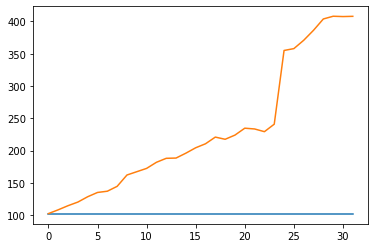

Rhode Island


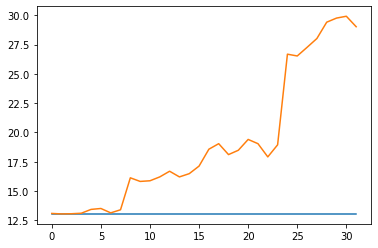

Alaska


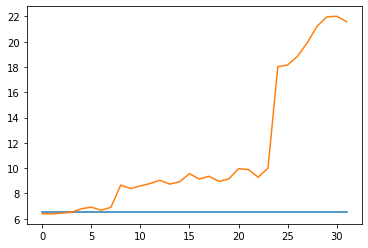

Delaware


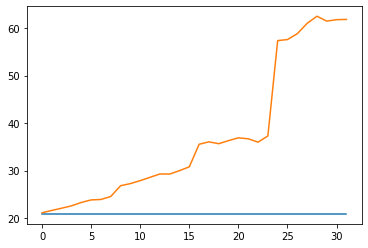

West Virginia


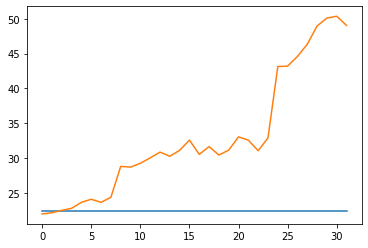

New Hampshire


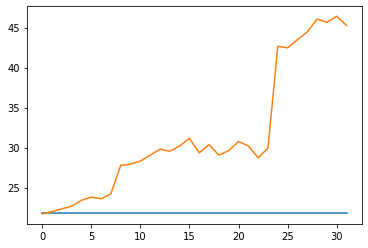

Nebraska


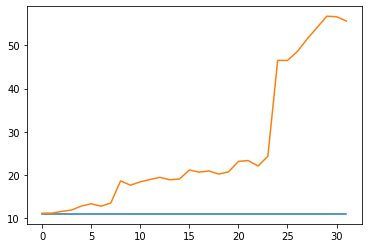

South Dakota


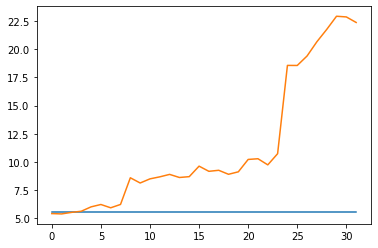

Hawaii


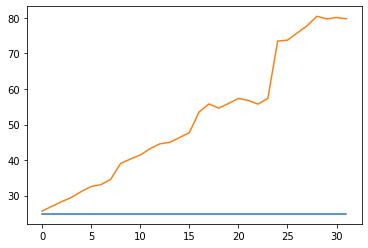

Connecticut


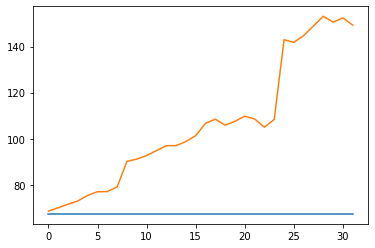

New Jersey


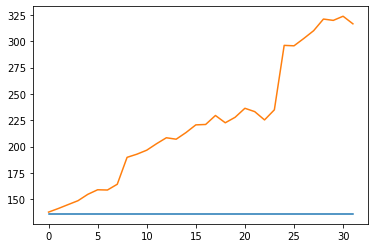

Wyoming


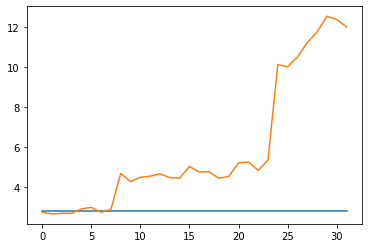

Utah


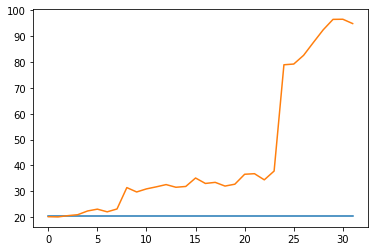

Montana


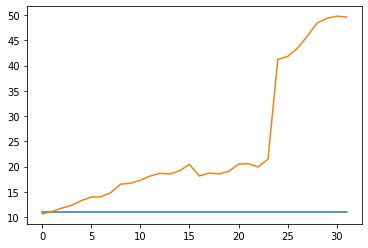

Michigan


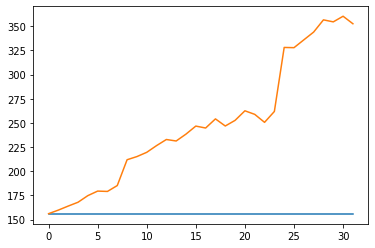

District of Columbia


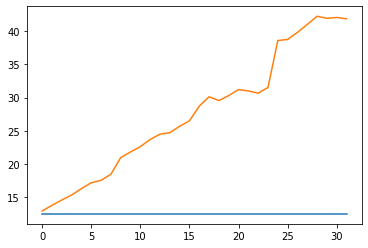

Idaho


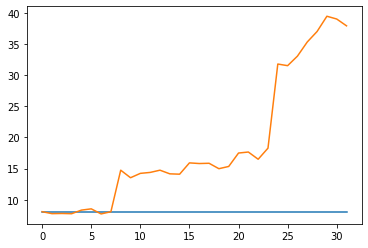

Nevada


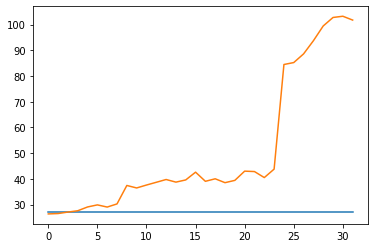

Iowa


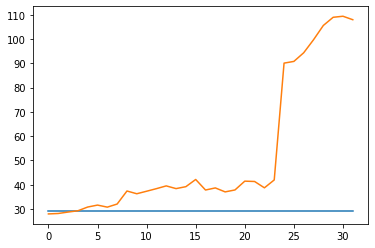

Maine


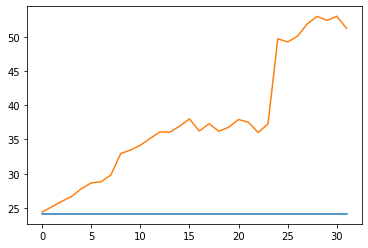

Massachusetts


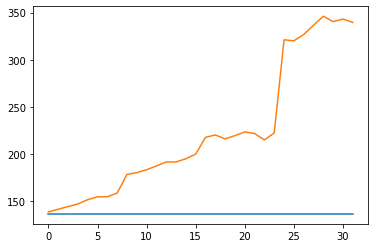

North Dakota


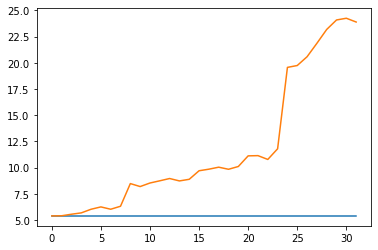

Oklahoma


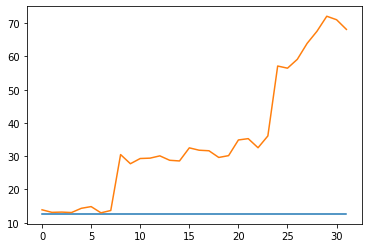

North Carolina


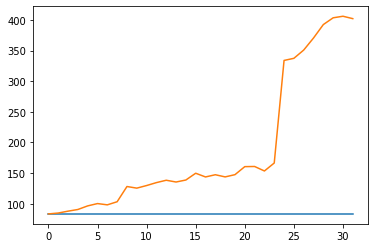

Tennessee


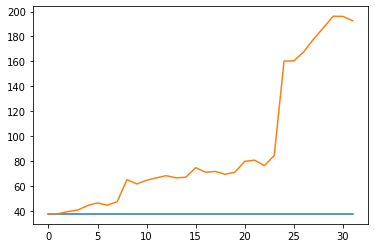

Kansas


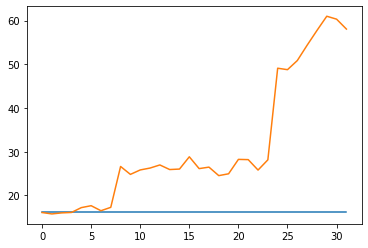

Minnesota


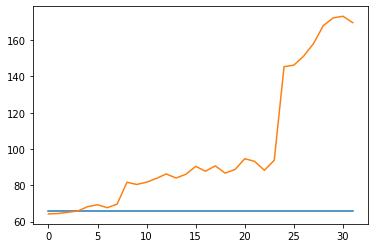

Arkansas


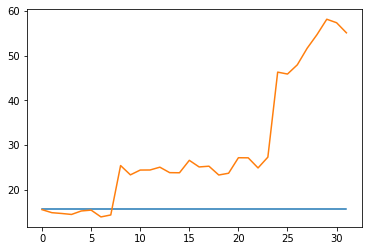

Mississippi


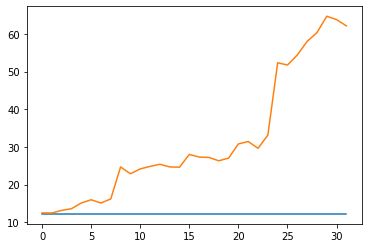

Arizona


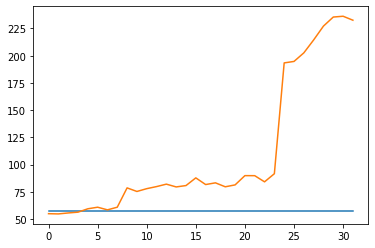

Missouri


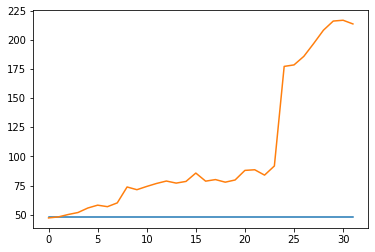

Louisiana


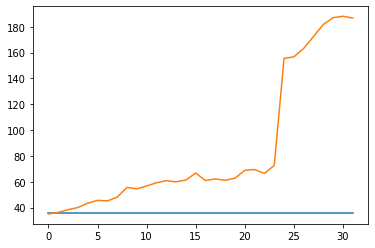

Oregon


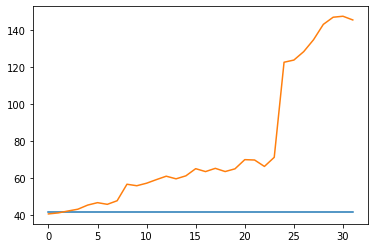

Illinois


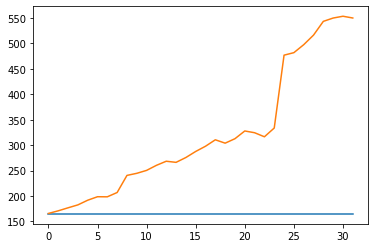

Indiana


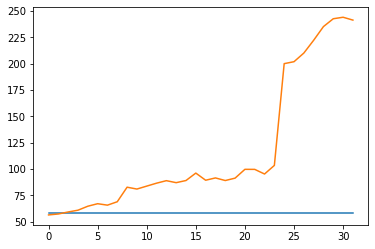

California


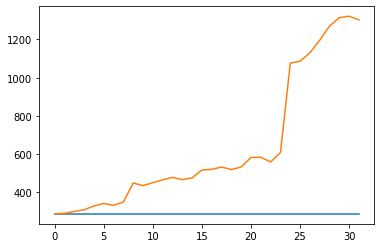

Wisconsin


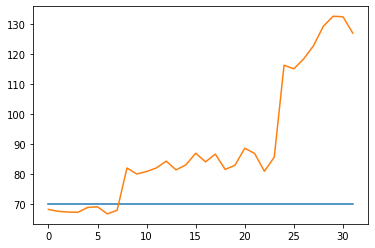

Virginia


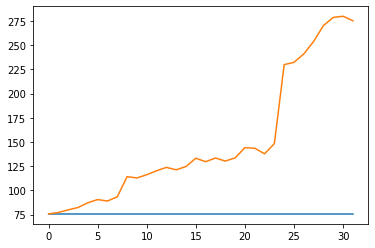

Maryland


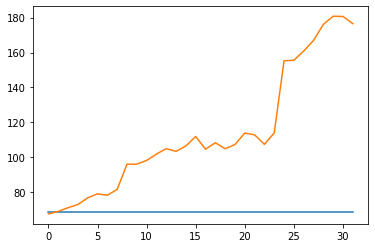

South Carolina


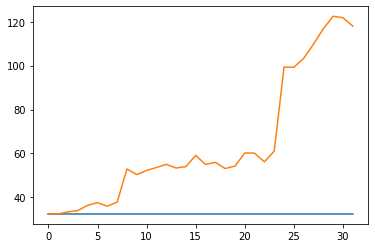

Pennsylvania


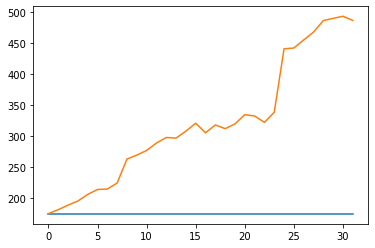

New York


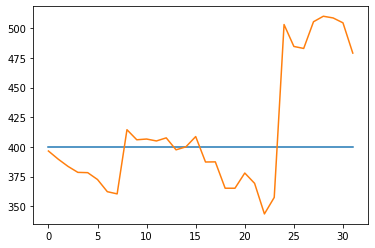

Florida


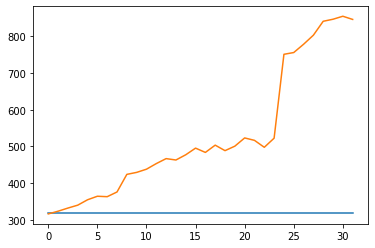

Ohio


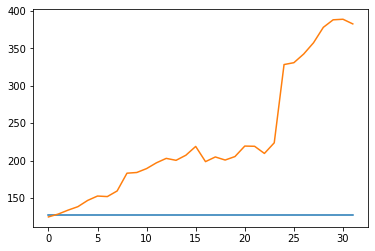

Texas


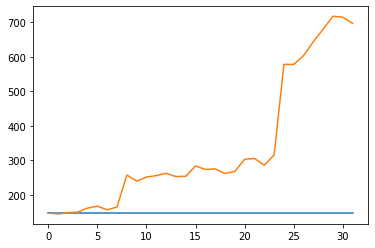

Alabama


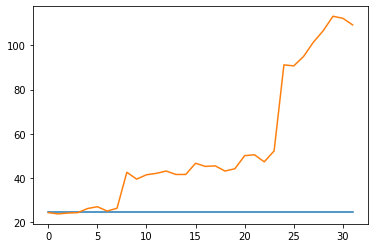

Colorado


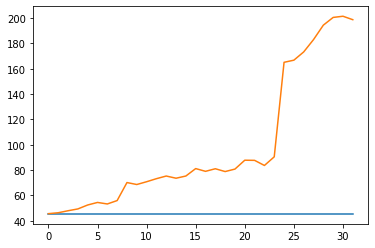

Georgia


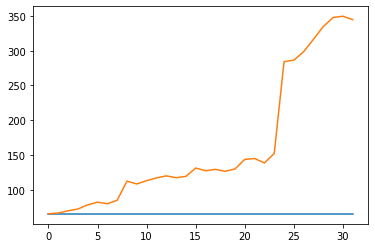

Kentucky


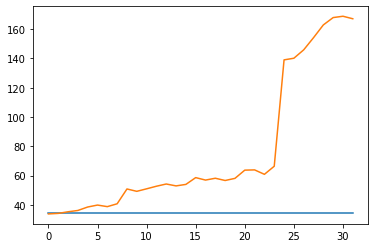

New Mexico


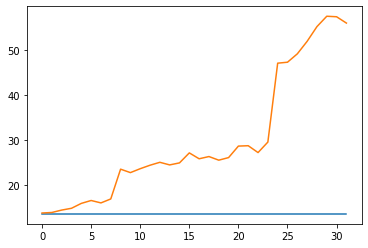

Vermont


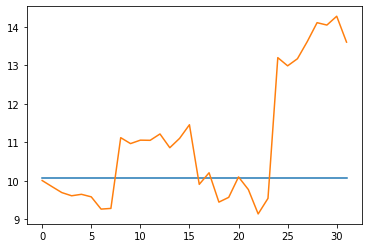

In [ ]:
for i in range(len(states)):
  print(states[i])
  plt.plot(inv_truth_v3_4wk[i,:])
  plt.plot(forecasts_ql_4wk[23//2][i,:])
  plt.show()

Washington


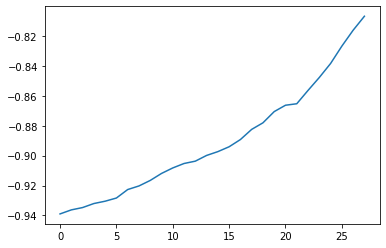

Rhode Island


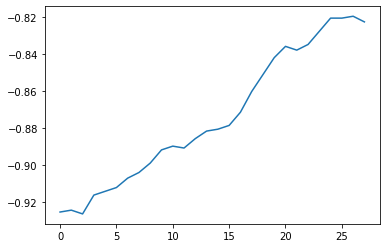

Alaska


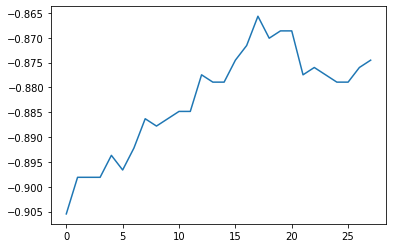

Delaware


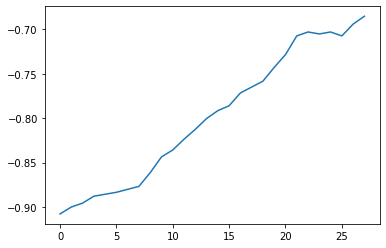

West Virginia


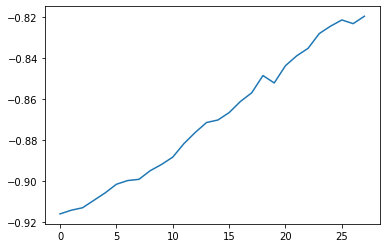

New Hampshire


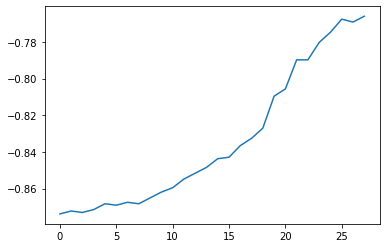

Nebraska


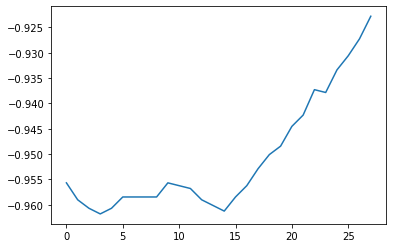

South Dakota


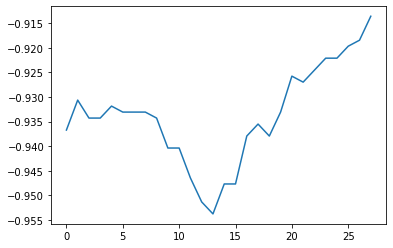

Hawaii


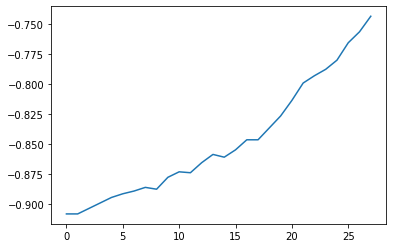

Connecticut


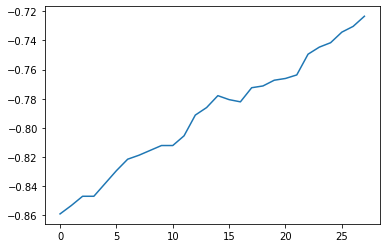

New Jersey


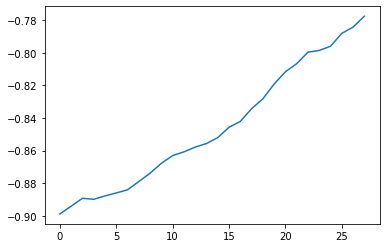

Wyoming


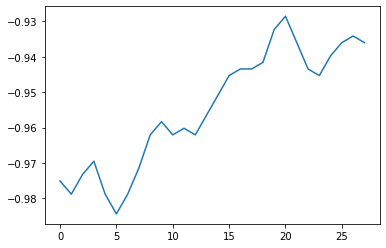

Utah


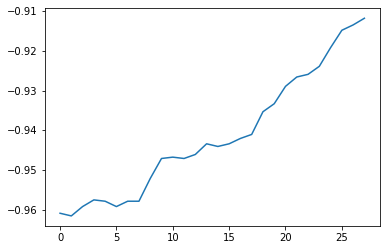

Montana


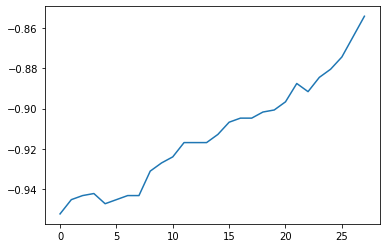

Michigan


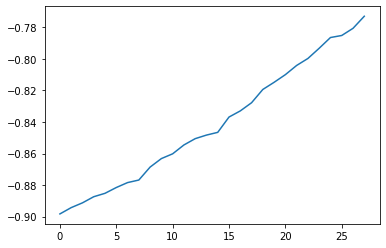

District of Columbia


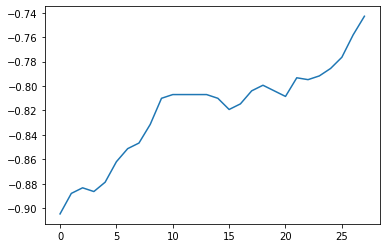

Idaho


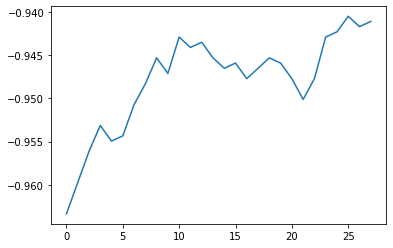

Nevada


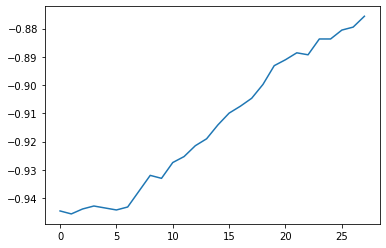

Iowa


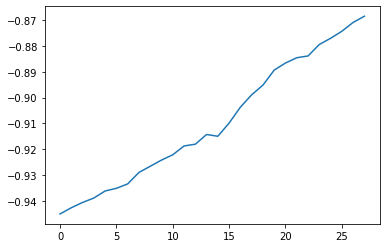

Maine


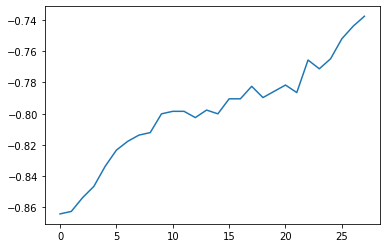

Massachusetts


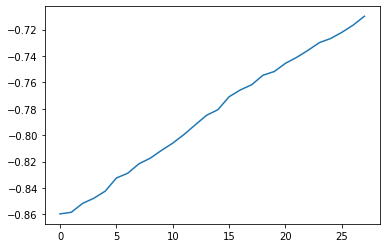

North Dakota


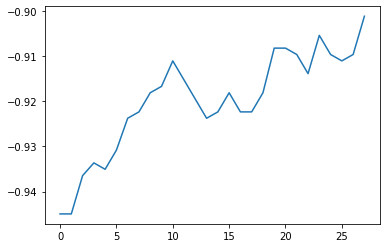

Oklahoma


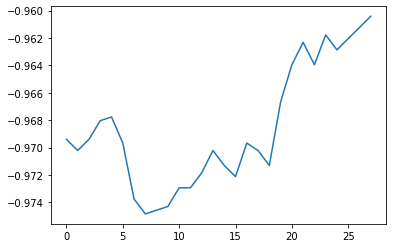

North Carolina


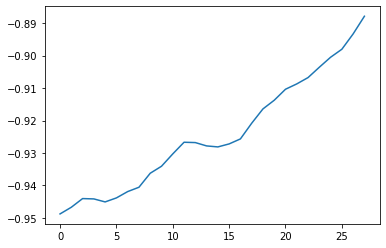

Tennessee


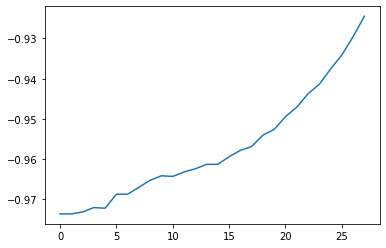

Kansas


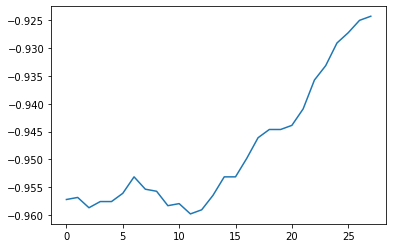

Minnesota


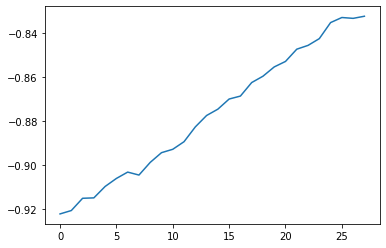

Arkansas


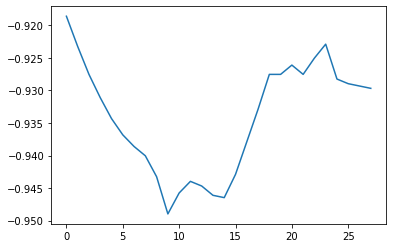

Mississippi


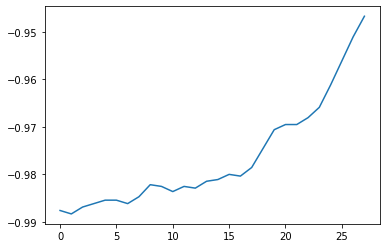

Arizona


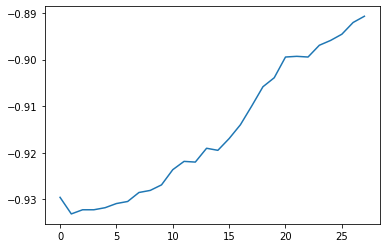

Missouri


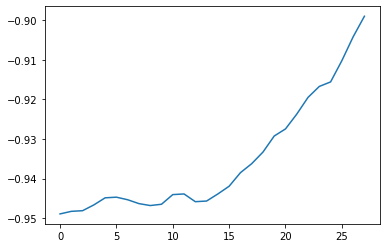

Louisiana


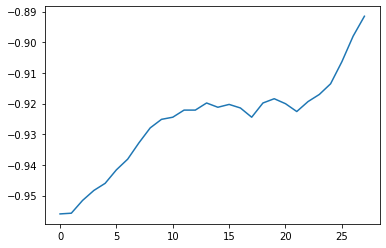

Oregon


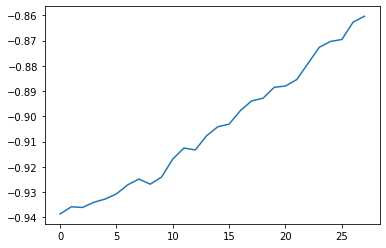

Illinois


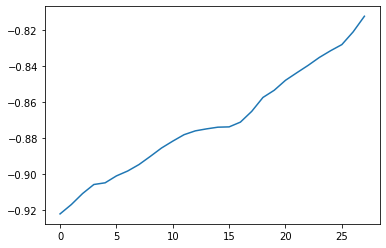

Indiana


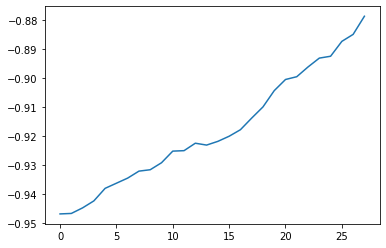

California


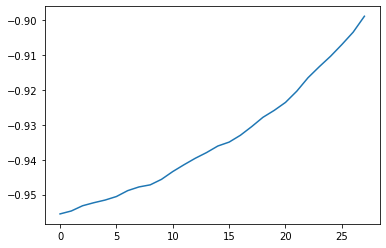

Wisconsin


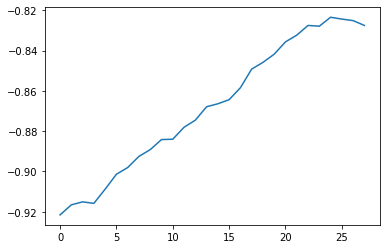

Virginia


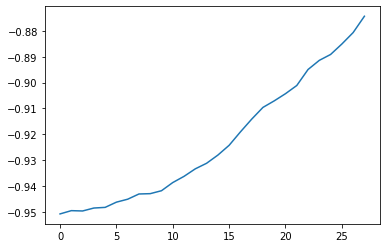

Maryland


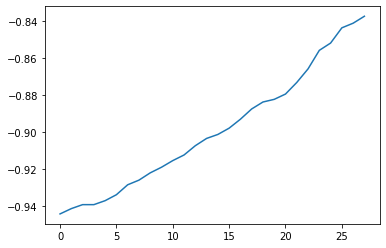

South Carolina


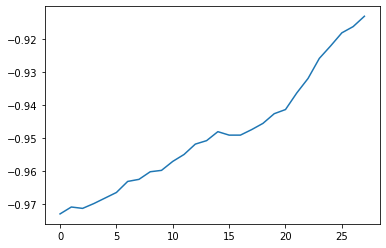

Pennsylvania


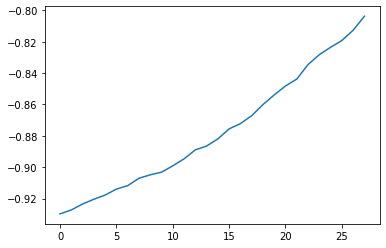

New York


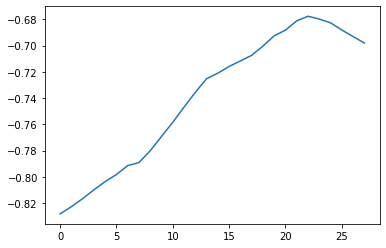

Florida


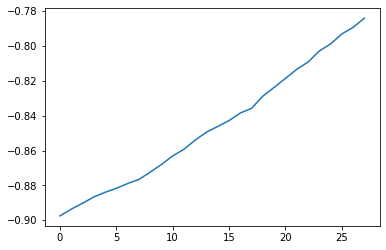

Ohio


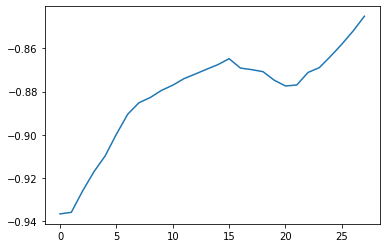

Texas


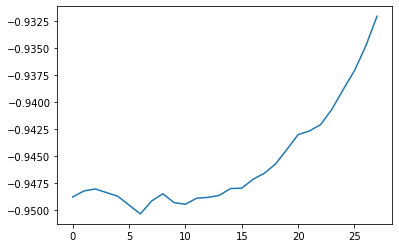

Alabama


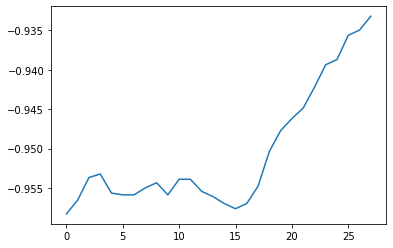

Colorado


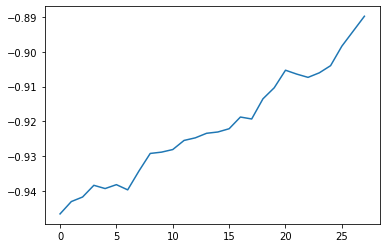

Georgia


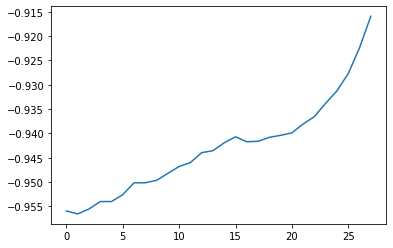

Kentucky


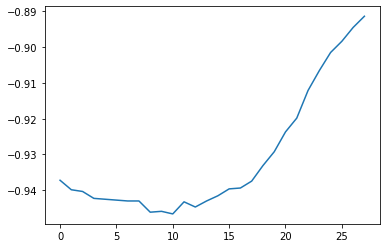

New Mexico


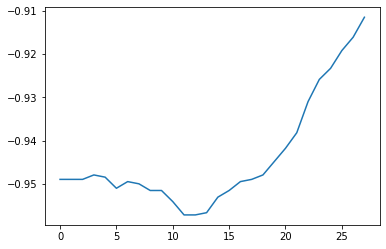

Vermont


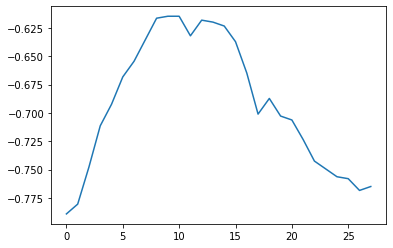

In [ ]:
for i in range(len(states)):
  print(states[i])
  plt.plot(input_test[i])
  plt.show()